# Setup env, Download data and models

In [39]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

# Base path for all project files
BASE_PATH = "/content/drive/MyDrive/Astra/"

# Create directory structure
DIRS = {
    'root': BASE_PATH,
    'data': os.path.join(BASE_PATH, 'data'),
    'data_semantickitti': os.path.join(BASE_PATH, 'data/SemanticKITTI'),
    'data_acdc': os.path.join(BASE_PATH, 'data/ACDC'),
    'data_cityscapes': os.path.join(BASE_PATH, 'data/Cityscapes'),
    'models': os.path.join(BASE_PATH, 'models'),
    'models_clip': os.path.join(BASE_PATH, 'models/clip'),
    'models_monoscene': os.path.join(BASE_PATH, 'models/monoscene'),
    'models_checkpoints': os.path.join(BASE_PATH, 'models/checkpoints'),
    'code': os.path.join(BASE_PATH, 'code'),
    'code_monoscene': os.path.join(BASE_PATH, 'code/MonoScene'),
    'code_poda': os.path.join(BASE_PATH, 'code/PODA'),
    'code_project': os.path.join(BASE_PATH, 'code/poda_monoscene'),
    'outputs': os.path.join(BASE_PATH, 'outputs'),
    'outputs_styles': os.path.join(BASE_PATH, 'outputs/mined_styles'),
    'outputs_predictions': os.path.join(BASE_PATH, 'outputs/predictions'),
    'outputs_visualizations': os.path.join(BASE_PATH, 'outputs/visualizations'),
    'logs': os.path.join(BASE_PATH, 'logs'),
    'configs': os.path.join(BASE_PATH, 'configs'),
}

print("Creating directory structure...")
for name, path in DIRS.items():
    os.makedirs(path, exist_ok=True)
    print(f"  ✓ {name}: {path}")

print("\n✅ Directory structure created!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating directory structure...
  ✓ root: /content/drive/MyDrive/Astra/
  ✓ data: /content/drive/MyDrive/Astra/data
  ✓ data_semantickitti: /content/drive/MyDrive/Astra/data/SemanticKITTI
  ✓ data_acdc: /content/drive/MyDrive/Astra/data/ACDC
  ✓ data_cityscapes: /content/drive/MyDrive/Astra/data/Cityscapes
  ✓ models: /content/drive/MyDrive/Astra/models
  ✓ models_clip: /content/drive/MyDrive/Astra/models/clip
  ✓ models_monoscene: /content/drive/MyDrive/Astra/models/monoscene
  ✓ models_checkpoints: /content/drive/MyDrive/Astra/models/checkpoints
  ✓ code: /content/drive/MyDrive/Astra/code
  ✓ code_monoscene: /content/drive/MyDrive/Astra/code/MonoScene
  ✓ code_poda: /content/drive/MyDrive/Astra/code/PODA
  ✓ code_project: /content/drive/MyDrive/Astra/code/poda_monoscene
  ✓ outputs: /content/drive/MyDrive/Astra/outputs
  ✓ outputs_styles: /content/drive/MyD

In [5]:

%%capture
!pip install pytorch-lightning==1.9.5
!pip install hydra-core==1.3.2
!pip install omegaconf==2.3.0

# CLIP
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# 3D Processing
!pip install open3d==0.17.0
!pip install trimesh==3.23.5

# Visualization
!pip install wandb==0.15.8

# Data handling
!pip install h5py==3.9.0
!pip install pyyaml==6.0.1

# Additional
!pip install einops==0.6.1
!pip install timm==0.9.2
!pip install Open3D



print("Verifying installation...")

import torch
print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

import clip
print("✓ CLIP installed")

import cv2
print(f"✓ OpenCV: {cv2.__version__}")

import open3d as o3d
print(f"✓ Open3D: {o3d.__version__}")

print("\n✅ All dependencies installed!")

In [6]:
os.chdir(DIRS['code'])

# Clone MonoScene
if not os.path.exists(DIRS['code_monoscene']):
    !git clone https://github.com/astra-vision/MonoScene.git
    print("✓ MonoScene cloned")
else:
    print("✓ MonoScene already exists")

# Clone PODA
if not os.path.exists(DIRS['code_poda']):
    !git clone https://github.com/astra-vision/PODA.git
    print("✓ PODA cloned")
else:
    print("✓ PODA already exists")

print("\n✅ Repositories ready!")

✓ MonoScene already exists
✓ PODA already exists

✅ Repositories ready!


In [7]:
import torch
import clip

clip_models = ['RN50', 'RN101']

for model_name in clip_models:
    save_path = os.path.join(DIRS['models_clip'], f'clip_{model_name.lower()}.pt')

    if not os.path.exists(save_path):
        print(f"Downloading CLIP {model_name}...")
        model, preprocess = clip.load(model_name, device='cpu')
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_name': model_name,
        }, save_path)
        print(f"  ✓ Saved to {save_path}")
        del model
    else:
        print(f"✓ CLIP {model_name} already exists")

print("\n✅ CLIP models ready!")

✓ CLIP RN50 already exists
✓ CLIP RN101 already exists

✅ CLIP models ready!


In [8]:
config_content = f"""# PODA + MonoScene Configuration

paths:
  base: "{BASE_PATH}"
  data:
    semantickitti: "{DIRS['data_semantickitti']}"
    acdc: "{DIRS['data_acdc']}"
    cityscapes: "{DIRS['data_cityscapes']}"
  models:
    clip: "{DIRS['models_clip']}"
    monoscene: "{DIRS['models_monoscene']}"
    checkpoints: "{DIRS['models_checkpoints']}"
  outputs:
    styles: "{DIRS['outputs_styles']}"
    predictions: "{DIRS['outputs_predictions']}"
    visualizations: "{DIRS['outputs_visualizations']}"
  logs: "{DIRS['logs']}"

model:
  backbone_2d:
    name: "RN50"
    pretrained: true
    frozen: true
  unet_3d:
    in_channels: 256
    base_channels: 64
    num_layers: 2
  crp_3d:
    num_relations: 4
    supervoxel_size: 4
    use_supervision: true
  completion_head:
    aspp_dilations: [1, 2, 3]
    num_classes: 20

poda:
  style_mining:
    num_iterations: 100
    learning_rate: 1.0
    momentum: 0.9
    batch_size: 16
    feature_layer: "layer1"
  prompts:
    fog: "driving in fog"
    rain: "driving under rain"
    snow: "driving in snow"

training:
  source_only:
    epochs: 30
    batch_size: 4
    learning_rate: 1.0e-3
    weight_decay: 1.0e-4
  adaptation:
    epochs: 10
    batch_size: 8
    learning_rate: 1.0e-2
    iterations: 2000

losses:
  cross_entropy: 1.0
  scal_sem: 1.0
  scal_geo: 1.0
  frustum_proportion: 1.0
  relation: 1.0
"""

config_path = os.path.join(DIRS['configs'], 'config.yaml')
with open(config_path, 'w') as f:
    f.write(config_content)
print(f"✓ Config saved to: {config_path}")

✓ Config saved to: /content/drive/MyDrive/Astra/configs/config.yaml


# Implement CLIP backbone wrapper with PIN

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from collections import OrderedDict


In [11]:
class FLoSPProjector(nn.Module):
    """
    Adapts CLIP backbone features to MonoScene's FLoSP expectations.

    CLIP RN50 features:
    - layer1: 256 channels
    - layer2: 512 channels
    - layer3: 1024 channels
    - layer4: 2048 channels

    MonoScene FLoSP expects features at scales 1, 2, 4, 8
    with consistent channel dimensions for summation.
    """

    def __init__(self, output_channels=64):
        """
        Args:
            output_channels: Number of output channels for all scales (for summation)
        """
        super().__init__()

        self.output_channels = output_channels

        # 1x1 convolutions to project to common channel dimension
        # These allow features to be summed in FLoSP
        self.proj_scale1 = nn.Conv2d(256, output_channels, kernel_size=1, bias=False)
        self.proj_scale2 = nn.Conv2d(512, output_channels, kernel_size=1, bias=False)
        self.proj_scale4 = nn.Conv2d(1024, output_channels, kernel_size=1, bias=False)
        self.proj_scale8 = nn.Conv2d(2048, output_channels, kernel_size=1, bias=False)

        self._init_weights()

    def _init_weights(self):
        """Initialize projection weights."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, features):
        """
        Project multi-scale features to common channel dimension.

        Args:
            features: Dict from CLIPBackbone with keys 'scale_1', 'scale_2', etc.

        Returns:
            projected: Dict with same keys but projected to output_channels
        """
        projected = {
            'scale_1': self.proj_scale1(features['scale_1']),
            'scale_2': self.proj_scale2(features['scale_2']),
            'scale_4': self.proj_scale4(features['scale_4']),
            'scale_8': self.proj_scale8(features['scale_8']),
        }
        return projected


# Test the projector
if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Create projector
    projector = FLoSPProjector(output_channels=64).to(device)

    # Test with dummy features
    features = {
        'scale_1': torch.randn(2, 256, 120, 160).to(device),
        'scale_2': torch.randn(2, 512, 60, 80).to(device),
        'scale_4': torch.randn(2, 1024, 30, 40).to(device),
        'scale_8': torch.randn(2, 2048, 15, 20).to(device),
    }

    projected = projector(features)

    print("Projected feature shapes:")
    for name, feat in projected.items():
        print(f"  {name}: {feat.shape}")

    print("\n✓ FLoSP Projector test passed!")

Projected feature shapes:
  scale_1: torch.Size([2, 64, 120, 160])
  scale_2: torch.Size([2, 64, 60, 80])
  scale_4: torch.Size([2, 64, 30, 40])
  scale_8: torch.Size([2, 64, 15, 20])

✓ FLoSP Projector test passed!


In [12]:
class ContextRelationPrior3D(nn.Module):
    """
    3D Context Relation Prior (3D CRP).

    Learns voxel-to-voxel semantic relations to enhance context awareness.
    Based on MonoScene paper Section 3.2.

    Uses supervoxel-to-voxel relations to reduce memory:
    - Supervoxels: non-overlapping groups of s³ voxels
    - Relations: {free-similar, free-different, occ-similar, occ-different}
    """

    def __init__(self, in_channels, num_relations=4, supervoxel_size=2):
        """
        Args:
            in_channels: Input feature channels
            num_relations: Number of relation types (default 4)
            supervoxel_size: Size of supervoxel groups (s)
        """
        super().__init__()

        self.in_channels = in_channels
        self.num_relations = num_relations
        self.supervoxel_size = supervoxel_size

        # ASPP for gathering context before relation computation
        self.aspp = nn.Sequential(
            nn.Conv3d(in_channels, in_channels, kernel_size=1, bias=False),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=2, dilation=2, bias=False),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True),
        )

        # Relation matrix predictors (one per relation type)
        # Output: probability of each relation type
        self.relation_conv = nn.Conv3d(
            in_channels, num_relations,
            kernel_size=1, bias=True
        )

        # Context aggregation
        self.context_conv = nn.Sequential(
            nn.Conv3d(in_channels * 2, in_channels, kernel_size=1, bias=False),
            nn.BatchNorm3d(in_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, return_relations=False):
        """
        Forward pass.

        Args:
            x: Input features [B, C, X, Y, Z]
            return_relations: If True, also return relation matrices

        Returns:
            out: Context-enhanced features [B, C, X, Y, Z]
            relations: (optional) Relation matrices
        """
        B, C, X, Y, Z = x.shape

        # Apply ASPP
        feat = self.aspp(x)

        # Compute relation logits
        relations = self.relation_conv(feat)  # [B, num_relations, X, Y, Z]
        relations = torch.sigmoid(relations)

        # Create supervoxel features by average pooling
        s = self.supervoxel_size
        if X % s != 0 or Y % s != 0 or Z % s != 0:
            # Pad if needed
            pad_x = (s - X % s) % s
            pad_y = (s - Y % s) % s
            pad_z = (s - Z % s) % s
            feat_padded = F.pad(feat, (0, pad_z, 0, pad_y, 0, pad_x))
        else:
            feat_padded = feat

        # Average pool to get supervoxel features
        supervoxel_feat = F.avg_pool3d(feat_padded, kernel_size=s, stride=s)

        # Upsample back to original size
        supervoxel_feat_up = F.interpolate(
            supervoxel_feat, size=(X, Y, Z),
            mode='trilinear', align_corners=False
        )

        # Combine original and context features
        combined = torch.cat([feat, supervoxel_feat_up], dim=1)
        out = self.context_conv(combined)

        # Residual connection
        out = out + x

        if return_relations:
            return out, relations
        return out



# SemanticKITTI dataloade

In [13]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
from typing import Dict, List, Tuple, Optional
import yaml



In [14]:

def get_intrinsic_matrix(fx: float, fy: float, cx: float, cy: float) -> np.ndarray:
    """Create 3x3 intrinsic matrix."""
    return np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ], dtype=np.float32)


SEMANTICKITTI_PATH = os.path.join(DIRS['data_semantickitti'], 'dataset')


# Test reading a voxel file to check format
test_voxel_dir = os.path.join(SEMANTICKITTI_PATH, 'dataset', 'sequences', '08', 'voxels')
if os.path.exists(test_voxel_dir):
    voxel_files = sorted(os.listdir(test_voxel_dir))[:5]
    print(f"\nSample voxel files in sequence 08:")
    for f in voxel_files:
        fpath = os.path.join(test_voxel_dir, f)
        fsize = os.path.getsize(fpath)
        print(f"  {f}: {fsize} bytes")

    # Check expected sizes
    num_voxels = 256 * 256 * 32
    print(f"\nExpected sizes for {num_voxels} voxels:")
    print(f"  .label (uint16): {num_voxels * 2} bytes")
    print(f"  .invalid (bitmask): {num_voxels // 8} bytes")
    print(f"  .bin (bitmask): {num_voxels // 8} bytes")

print("\n✓ Utility functions defined (v2)")


✓ Utility functions defined (v2)


In [15]:
def project_voxels_to_image(
    centroids: torch.Tensor,
    intrinsic: torch.Tensor,
    img_size: Tuple[int, int] = (1220, 370),
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Project voxel centroids to image coordinates.

    Args:
        centroids: (N, 3) voxel centroids in camera coordinates
        intrinsic: (4, 4) camera intrinsic matrix
        img_size: (W, H) image size

    Returns:
        uv: (N, 2) image coordinates
        valid: (N,) boolean mask for valid projections
    """
    N = centroids.shape[0]

    # Add homogeneous coordinate
    ones = torch.ones(N, 1, device=centroids.device, dtype=centroids.dtype)
    centroids_h = torch.cat([centroids, ones], dim=1)  # (N, 4)

    # Project to image
    proj = centroids_h @ intrinsic.T  # (N, 4)

    # Normalize by depth
    z = proj[:, 2:3].clamp(min=1e-5)
    uv = proj[:, :2] / z  # (N, 2)

    # Check validity
    W, H = img_size
    valid = (
        (z.squeeze() > 0.1) &  # In front of camera
        (uv[:, 0] >= 0) & (uv[:, 0] < W) &  # Within image width
        (uv[:, 1] >= 0) & (uv[:, 1] < H)    # Within image height
    )

    return uv, valid


def get_projection_matrix(
    voxel_size: Tuple[int, int, int] = (256, 256, 32),
    scene_size: Tuple[float, float, float] = (51.2, 51.2, 6.4),
    voxel_origin: Tuple[float, float, float] = (0, -25.6, -2),
    intrinsic: Optional[torch.Tensor] = None,
    img_size: Tuple[int, int] = (1220, 370),
) -> Dict[str, torch.Tensor]:
    """
    Precompute projection information for FLoSP.

    Returns dictionary with:
        - centroids: (N, 3) voxel centroids
        - uv: (N, 2) projected image coordinates (if intrinsic provided)
        - valid: (N,) valid projection mask (if intrinsic provided)
    """
    centroids = compute_voxel_centroids(voxel_size, scene_size, voxel_origin)

    result = {'centroids': centroids}

    if intrinsic is not None:
        uv, valid = project_voxels_to_image(centroids, intrinsic, img_size)
        result['uv'] = uv
        result['valid'] = valid

    return result


print("✓ Projection helpers defined")

✓ Projection helpers defined


In [ ]:
SEMANTICKITTI_PATH = os.path.join(DIRS['data_semantickitti'], 'dataset')

# Check if data exists
sequences_path = os.path.join(SEMANTICKITTI_PATH, 'sequences')



# Check data structure first
seq_08_path = os.path.join(SEMANTICKITTI_PATH, 'sequences', '08')
if os.path.exists(seq_08_path):
    print(f"Checking sequence 08 structure:")
    for item in os.listdir(seq_08_path):
        item_path = os.path.join(seq_08_path, item)
        if os.path.isdir(item_path):
            num_files = len(os.listdir(item_path))
            print(f"  {item}/: {num_files} files")
        else:
            print(f"  {item}")

# Create validation dataloader
try:
    val_loader = create_semantickitti_dataloader(
        root=SEMANTICKITTI_PATH,
        split='val',
        batch_size=2,
        num_workers=0,  # Use 0 for testing in Colab
        augment=False,
    )

    print(f"\n✓ Validation dataloader created")
    print(f"  Samples: {len(val_loader.dataset)}")
    print(f"  Batches: {len(val_loader)}")

    # Test loading a batch
    print("\nTesting batch loading...")
    for batch in val_loader:
        print(f"\n✓ Batch loaded successfully!")
        print(f"  Image shape: {batch['image'].shape}")
        print(f"  Intrinsic shape: {batch['intrinsic'].shape}")
        if 'label' in batch:
            print(f"  Label shape: {batch['label'].shape}")
            print(f"  Label unique values: {torch.unique(batch['label']).tolist()[:10]}...")
        if 'invalid' in batch:
            print(f"  Invalid mask shape: {batch['invalid'].shape}")
            print(f"  Invalid ratio: {batch['invalid'].float().mean().item():.2%}")
        print(f"  Sequences: {batch['sequence']}")
        print(f"  Frame IDs: {batch['frame_id']}")
        break

except Exception as e:
    print(f"⚠ Error creating dataloader: {e}")
    import traceback
    traceback.print_exc()

# Writing the files

In [17]:
utils_code = '''"""Utility functions for PODA + MonoScene project"""

import os
import yaml
import torch
import numpy as np
from typing import Dict, Tuple, Optional


def load_config(config_path: str) -> dict:
    with open(config_path, "r") as f:
        return yaml.safe_load(f)


def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device


def seed_everything(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = self.avg = self.sum = self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def compute_iou(pred, target, num_classes):
    pred_occ = pred > 0
    target_occ = target > 0
    intersection = np.logical_and(pred_occ, target_occ).sum()
    union = np.logical_or(pred_occ, target_occ).sum()
    iou = intersection / (union + 1e-6)

    class_iou = np.zeros(num_classes)
    for c in range(num_classes):
        inter = np.logical_and(pred == c, target == c).sum()
        uni = np.logical_or(pred == c, target == c).sum()
        class_iou[c] = inter / uni if uni > 0 else np.nan
    return iou, class_iou


def save_checkpoint(state, save_path, filename="checkpoint.pth"):
    os.makedirs(save_path, exist_ok=True)
    torch.save(state, os.path.join(save_path, filename))


SEMANTICKITTI_CLASSES = {
    0: "unlabeled", 1: "car", 2: "bicycle", 3: "motorcycle",
    4: "truck", 5: "other-vehicle", 6: "person", 7: "bicyclist",
    8: "motorcyclist", 9: "road", 10: "parking", 11: "sidewalk",
    12: "other-ground", 13: "building", 14: "fence", 15: "vegetation",
    16: "trunk", 17: "terrain", 18: "pole", 19: "traffic-sign"
}

SEMANTICKITTI_COLORS = np.array([
    [0, 0, 0], [100, 150, 245], [100, 230, 245], [30, 60, 150],
    [80, 30, 180], [100, 80, 250], [155, 30, 30], [255, 40, 200],
    [150, 30, 90], [255, 0, 255], [255, 150, 255], [75, 0, 75],
    [175, 0, 75], [255, 200, 0], [255, 120, 50], [0, 175, 0],
    [135, 60, 0], [150, 240, 80], [255, 240, 150], [255, 0, 0]
], dtype=np.uint8)
'''

os.makedirs(DIRS['code_project'], exist_ok=True)
utils_path = os.path.join(DIRS['code_project'], 'utils.py')
with open(utils_path, 'w') as f:
    f.write(utils_code)
print(f"✓ Utils saved to: {utils_path}")

# Add to path
sys.path.insert(0, DIRS['code_project'])

✓ Utils saved to: /content/drive/MyDrive/Astra/code/poda_monoscene/utils.py


In [18]:
import os

# Create directory structure
base_dir = '/content/drive/MyDrive/Astra/code/poda_monoscene'
os.makedirs(base_dir, exist_ok=True)

# PIN Layer module
pin_layer_code = '''"""
Prompt-driven Instance Normalization (PIN) layer for PØDA.

Based on: Fahes et al., "PØDA: Prompt-driven Zero-shot Domain Adaptation" (2023)
"""

import torch
import torch.nn as nn



class PINAugmenter(nn.Module):
    """Wrapper for PIN with style bank sampling."""

    def __init__(self, num_channels=256, eps=1e-6):
        super().__init__()
        self.pin = PromptDrivenInstanceNorm(num_channels, eps)
        self.style_bank = None

    def set_style_bank(self, style_bank):
        """Set the style bank from mined styles."""
        if isinstance(style_bank, dict):
            self.style_bank = style_bank
        else:
            mus = torch.stack([s[0] for s in style_bank])
            sigmas = torch.stack([s[1] for s in style_bank])
            self.style_bank = {'mu': mus, 'sigma': sigmas}

    def forward(self, f_s, mu_t=None, sigma_t=None, sample_style=False):
        """Forward pass with optional style sampling."""
        if sample_style and self.style_bank is not None and mu_t is None:
            idx = torch.randint(0, len(self.style_bank['mu']), (f_s.size(0),))
            mu_t = self.style_bank['mu'][idx].to(f_s.device)
            sigma_t = self.style_bank['sigma'][idx].to(f_s.device)

        return self.pin(f_s, mu_t, sigma_t)
'''

with open(os.path.join(base_dir, 'pin_layer.py'), 'w') as f:
    f.write(pin_layer_code)
print(f"✓ Saved pin_layer.py")

# CLIP Backbone module
clip_backbone_code = '''"""
CLIP ResNet-50 backbone wrapper for MonoScene integration.

Provides:
- Multi-scale feature extraction for FLoSP
- PIN integration point after layer1
- CLIP embedding computation for style mining
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import clip

from .pin_layer import PINAugmenter





class CLIPBackboneWithPIN(nn.Module):
    """Convenience wrapper combining CLIPBackbone with PIN layer."""

    def __init__(self, clip_model_name='RN50', pretrained=True, freeze=True, device='cuda'):
        super().__init__()
        self.pin = PINAugmenter(num_channels=256)
        self.backbone = CLIPBackbone(
            clip_model_name=clip_model_name,
            pretrained=pretrained,
            freeze=freeze,
            pin_layer=self.pin,
            device=device
        )
        self.feature_dims = self.backbone.feature_dims

    def forward(self, x, apply_pin=False, pin_mu=None, pin_sigma=None):
        return self.backbone(x, return_features=True, apply_pin=apply_pin,
                           pin_mu=pin_mu, pin_sigma=pin_sigma)

    def set_style_bank(self, style_bank):
        self.pin.set_style_bank(style_bank)

    def get_layer1_features(self, x):
        return self.backbone.get_layer1_features(x)

    def get_clip_embedding(self, x):
        return self.backbone.get_clip_embedding(x)

    def forward_from_layer1(self, f_layer1):
        return self.backbone.forward_from_layer1(f_layer1)
'''

with open(os.path.join(base_dir, 'clip_backbone.py'), 'w') as f:
    f.write(clip_backbone_code)
print(f"✓ Saved clip_backbone.py")

# Create __init__.py
init_code = '''"""
PØDA + MonoScene Integration Package

Modules:
- pin_layer: Prompt-driven Instance Normalization
- clip_backbone: CLIP ResNet-50 backbone wrapper
"""

from .pin_layer import PromptDrivenInstanceNorm, PINAugmenter
from .clip_backbone import CLIPBackbone, CLIPBackboneWithPIN

__all__ = [
    'PromptDrivenInstanceNorm',
    'PINAugmenter',
    'CLIPBackbone',
    'CLIPBackboneWithPIN',
]
'''

with open(os.path.join(base_dir, '__init__.py'), 'w') as f:
    f.write(init_code)
print(f"✓ Saved __init__.py")

print(f"\n✓ All modules saved to {base_dir}")

✓ Saved pin_layer.py
✓ Saved clip_backbone.py
✓ Saved __init__.py

✓ All modules saved to /content/drive/MyDrive/Astra/code/poda_monoscene


In [29]:

import os
base_dir = '/content/drive/MyDrive/Astra/code/poda_monoscene'
os.makedirs(base_dir, exist_ok=True)



# 3D UNet module
unet3d_code = '''"""
3D UNet components for MonoScene.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Tuple, Optional, List



class ASPP3D(nn.Module):
    """3D Atrous Spatial Pyramid Pooling."""

    def __init__(self, in_channels, out_channels, dilations=[1, 2, 3]):
        super().__init__()

        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv3d(in_channels, out_channels, 1, bias=False),
                         nn.BatchNorm3d(out_channels), nn.ReLU(inplace=True))
        ])
        for d in dilations:
            self.convs.append(nn.Sequential(
                nn.Conv3d(in_channels, out_channels, 3, padding=d, dilation=d, bias=False),
                nn.BatchNorm3d(out_channels), nn.ReLU(inplace=True)
            ))

        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(in_channels, out_channels, 1, bias=False),
            nn.GroupNorm(8, out_channels), nn.ReLU(inplace=True)
        )

        self.fusion = nn.Sequential(
            nn.Conv3d(out_channels * (len(dilations) + 2), out_channels, 1, bias=False),
            nn.BatchNorm3d(out_channels), nn.ReLU(inplace=True)
        )

    def forward(self, x):
        size = x.shape[2:]
        features = [conv(x) for conv in self.convs]
        global_feat = F.interpolate(self.global_pool(x), size=size, mode='trilinear', align_corners=False)
        features.append(global_feat)
        return self.fusion(torch.cat(features, dim=1))

'''

with open(os.path.join(base_dir, 'unet3d.py'), 'w') as f:
    f.write(unet3d_code)
print("✓ Saved unet3d.py")

# CRP module
crp_code = '''"""
3D Context Relation Prior for MonoScene.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Tuple, Optional, List


class SimplifiedCRP3D(nn.Module):
    """Simplified 3D CRP using self-attention."""

    def __init__(self, in_channels, reduction=4):
        super().__init__()
        mid_channels = in_channels // reduction

        self.query = nn.Conv3d(in_channels, mid_channels, 1)
        self.key = nn.Conv3d(in_channels, mid_channels, 1)
        self.value = nn.Conv3d(in_channels, in_channels, 1)

        self.out_proj = nn.Sequential(
            nn.Conv3d(in_channels, in_channels, 1, bias=False),
            nn.BatchNorm3d(in_channels)
        )
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, X, Y, Z = x.shape

        x_down = F.avg_pool3d(x, kernel_size=2, stride=2)
        _, _, X_d, Y_d, Z_d = x_down.shape

        q = self.query(x_down).view(B, -1, X_d * Y_d * Z_d)
        k = self.key(x_down).view(B, -1, X_d * Y_d * Z_d)
        v = self.value(x_down).view(B, -1, X_d * Y_d * Z_d)

        attn = F.softmax(torch.bmm(q.transpose(1, 2), k) / (q.size(1) ** 0.5), dim=-1)
        out = torch.bmm(v, attn.transpose(1, 2)).view(B, -1, X_d, Y_d, Z_d)

        out = F.interpolate(out, size=(X, Y, Z), mode='trilinear', align_corners=False)
        return self.gamma * self.out_proj(out) + x
'''

with open(os.path.join(base_dir, 'crp3d.py'), 'w') as f:
    f.write(crp_code)
print("✓ Saved crp3d.py")



# Update __init__.py
init_code = '''"""
PØDA + MonoScene Integration Package
"""

from .pin_layer import PromptDrivenInstanceNorm, PINAugmenter
from .clip_backbone import CLIPBackbone, CLIPBackboneWithPIN
from .style_mining import StyleMiner, MultiDomainStyleMiner
from .flosp import FLoSP, ProjectionHelper
from .unet3d import DDRBlock, ASPP3D, UNet3D
from .crp3d import SimplifiedCRP3D
from .monoscene_poda import MonoScenePODA, CompletionHead

__all__ = [
    'PromptDrivenInstanceNorm', 'PINAugmenter',
    'CLIPBackbone', 'CLIPBackboneWithPIN',
    'StyleMiner', 'MultiDomainStyleMiner',
    'FLoSP', 'ProjectionHelper',
    'DDRBlock', 'ASPP3D', 'UNet3D',
    'SimplifiedCRP3D',
    'MonoScenePODA', 'CompletionHead',
]
'''

with open(os.path.join(base_dir, '__init__.py'), 'w') as f:
    f.write(init_code)
print("✓ Updated __init__.py")

print(f"\n✓ All modules saved to {base_dir}")

# List saved files
print("\nSaved files:")
for f in os.listdir(base_dir):
    if f.endswith('.py'):
        filepath = os.path.join(base_dir, f)
        size = os.path.getsize(filepath)
        print(f"  {f}: {size} bytes")

✓ Saved unet3d.py
✓ Saved crp3d.py
✓ Updated __init__.py

✓ All modules saved to /content/drive/MyDrive/Astra/code/poda_monoscene

Saved files:
  flosp.py: 6726 bytes
  monoscene_poda.py: 5249 bytes
  utils.py: 2501 bytes
  pin_layer.py: 1273 bytes
  clip_backbone.py: 1455 bytes
  unet3d.py: 1511 bytes
  crp3d.py: 1405 bytes
  __init__.py: 691 bytes
  semantickitti_dataloader.py: 7510 bytes


In [21]:

dataloader_code = '''"""
SemanticKITTI Dataloader for PODA + MonoScene Integration.
"""

import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
from typing import Dict, List, Tuple, Optional

# Configuration
SEMANTICKITTI_CONFIG = {
    'voxel_size': (256, 256, 32),
    'voxel_resolution': 0.2,
    'scene_size': (51.2, 51.2, 6.4),
    'voxel_origin': (0, -25.6, -2),
    'img_size': (1220, 370),
    'original_img_size': (1226, 370),
    'train_sequences': ['00', '01', '02', '03', '04', '05', '06', '07', '09', '10'],
    'val_sequences': ['08'],
    'test_sequences': ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
}

SEMANTICKITTI_LABELS = {
    0: 0, 1: 0, 10: 1, 11: 2, 13: 5, 15: 3, 16: 5, 18: 4, 20: 5,
    30: 6, 31: 7, 32: 8, 40: 9, 44: 10, 48: 11, 49: 12, 50: 13,
    51: 14, 52: 0, 60: 9, 70: 15, 71: 16, 72: 17, 80: 18, 81: 19,
    99: 0, 252: 1, 253: 7, 254: 6, 255: 0, 256: 5, 257: 5, 258: 4, 259: 5,
}

CLASS_NAMES = [
    'empty', 'car', 'bicycle', 'motorcycle', 'truck', 'other-vehicle',
    'person', 'bicyclist', 'motorcyclist', 'road', 'parking', 'sidewalk',
    'other-ground', 'building', 'fence', 'vegetation', 'trunk', 'terrain',
    'pole', 'traffic-sign',
]

CLASS_WEIGHTS = torch.tensor([
    0.05, 1.0, 4.0, 4.0, 2.0, 2.0, 4.0, 4.0, 4.0, 0.3,
    1.5, 0.5, 2.0, 0.3, 1.5, 0.2, 3.0, 0.5, 3.0, 3.5,
], dtype=torch.float32)


def read_calib(calib_path: str) -> Dict[str, np.ndarray]:
    """Read SemanticKITTI calibration file with flexible key handling."""
    calib = {}
    with open(calib_path, 'r') as f:
        for line in f:
            line = line.strip()
            if ':' in line and line:
                key, value = line.split(':', 1)
                key = key.strip()
                value = value.strip()
                if value:
                    calib[key] = np.array([float(x) for x in value.split()])

    # Parse P2: 3x4 projection matrix for cam2
    P2 = None
    for key in ['P2', 'P_rect_02']:
        if key in calib:
            P2 = calib[key].reshape(3, 4)
            break
    if P2 is None:
        for key in calib:
            if key.startswith('P') and len(calib[key]) == 12:
                P2 = calib[key].reshape(3, 4)
                break

    # Parse Tr: transform from velodyne to cam0
    Tr_velo_to_cam = np.eye(4)
    for key in ['Tr', 'Tr_velo_to_cam', 'Tr_velo_cam']:
        if key in calib:
            Tr_velo_to_cam[:3, :4] = calib[key].reshape(3, 4)
            break

    # Parse R0_rect
    R0_rect = np.eye(4)
    for key in ['R0_rect', 'R_rect_00']:
        if key in calib:
            R0_rect[:3, :3] = calib[key].reshape(3, 3)
            break

    # Default P2 if not found
    if P2 is None:
        P2 = np.array([
            [707.0912, 0, 601.8873, 45.75],
            [0, 707.0912, 183.1104, 0],
            [0, 0, 1, 0]
        ], dtype=np.float32)

    return {
        'P2': P2, 'Tr_velo_to_cam': Tr_velo_to_cam, 'R0_rect': R0_rect,
        'intrinsic': P2[:3, :3], 'fx': P2[0, 0], 'fy': P2[1, 1],
        'cx': P2[0, 2], 'cy': P2[1, 2],
    }


def unpack_labels(compressed: np.ndarray) -> np.ndarray:
    """Unpack 4-bit labels (2 labels per byte)."""
    labels = np.zeros(len(compressed) * 2, dtype=np.uint8)
    labels[::2] = compressed & 0x0F
    labels[1::2] = (compressed >> 4) & 0x0F
    return labels


def unpack_bitmask(compressed: np.ndarray, num_voxels: int) -> np.ndarray:
    """Unpack bitmask (1 bit per voxel, 8 voxels per byte)."""
    unpacked = np.unpackbits(compressed, bitorder='little')
    return unpacked[:num_voxels]


def read_voxel_label(path: str, voxel_size: Tuple[int, int, int] = (256, 256, 32)) -> np.ndarray:
    """Read voxel label file (.label). Format: uint16 per voxel."""
    label = np.fromfile(path, dtype=np.uint16)
    semantic = label & 0xFFFF
    expected_size = voxel_size[0] * voxel_size[1] * voxel_size[2]
    if len(semantic) != expected_size:
        raise ValueError(f"Label size mismatch: {len(semantic)} vs {expected_size}")
    return semantic.reshape(voxel_size)


def read_voxel_invalid(path: str, voxel_size: Tuple[int, int, int] = (256, 256, 32)) -> np.ndarray:
    """Read invalid mask file (.invalid). Format: 1 bit per voxel (bitmask)."""
    num_voxels = voxel_size[0] * voxel_size[1] * voxel_size[2]
    raw = np.fromfile(path, dtype=np.uint8)

    if len(raw) * 8 >= num_voxels:
        invalid = unpack_bitmask(raw, num_voxels)
    elif len(raw) * 2 == num_voxels:
        invalid = unpack_labels(raw)
    elif len(raw) == num_voxels:
        invalid = raw
    else:
        invalid = np.zeros(num_voxels, dtype=np.uint8)

    return invalid.reshape(voxel_size).astype(bool)


def read_voxel_occupancy(path: str, voxel_size: Tuple[int, int, int] = (256, 256, 32)) -> np.ndarray:
    """Read occupancy file (.bin). Format: 1 bit per voxel (bitmask)."""
    num_voxels = voxel_size[0] * voxel_size[1] * voxel_size[2]
    raw = np.fromfile(path, dtype=np.uint8)
    if len(raw) * 8 >= num_voxels:
        occupancy = unpack_bitmask(raw, num_voxels)
    else:
        occupancy = np.zeros(num_voxels, dtype=np.uint8)
    return occupancy.reshape(voxel_size)


def remap_labels(labels: np.ndarray, label_mapping: Dict[int, int]) -> np.ndarray:
    """Remap labels to training format."""
    remapped = np.zeros_like(labels)
    for original, mapped in label_mapping.items():
        remapped[labels == original] = mapped
    return remapped





def semantickitti_collate_fn(batch: List[Dict]) -> Dict[str, torch.Tensor]:
    collated = {}

    # Always present
    collated['image'] = torch.stack([b['image'] for b in batch])
    collated['intrinsic'] = torch.stack([b['intrinsic'] for b in batch])
    collated['Tr_velo_to_cam'] = torch.stack([b['Tr_velo_to_cam'] for b in batch])  # ← ADD!
    collated['sequence'] = [b['sequence'] for b in batch]
    collated['frame_id'] = [b['frame_id'] for b in batch]

    # Optional
    if 'label' in batch[0]:
        collated['label'] = torch.stack([b['label'] for b in batch])
    if 'invalid' in batch[0]:
        collated['invalid'] = torch.stack([b['invalid'] for b in batch])

    return collated


def create_semantickitti_dataloader(root: str, split: str = 'train',
                                    batch_size: int = 4, num_workers: int = 4,
                                    augment: bool = True, **kwargs) -> DataLoader:
    """Create dataloader."""
    dataset = SemanticKITTIDataset(root=root, split=split,
                                   augment=augment and (split == 'train'), **kwargs)
    return DataLoader(dataset, batch_size=batch_size, shuffle=(split == 'train'),
                     num_workers=num_workers, collate_fn=semantickitti_collate_fn,
                     pin_memory=True, drop_last=(split == 'train'))


def compute_voxel_centroids(voxel_size=(256, 256, 32), scene_size=(51.2, 51.2, 6.4),
                            voxel_origin=(0, -25.6, -2)) -> torch.Tensor:
    """Compute voxel centroids in camera coordinates."""
    X, Y, Z = voxel_size
    sx, sy, sz = scene_size
    ox, oy, oz = voxel_origin
    res_x, res_y, res_z = sx / X, sy / Y, sz / Z

    x = torch.arange(X, dtype=torch.float32) * res_x + ox + res_x / 2
    y = torch.arange(Y, dtype=torch.float32) * res_y + oy + res_y / 2
    z = torch.arange(Z, dtype=torch.float32) * res_z + oz + res_z / 2

    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')
    return torch.stack([xx.flatten(), yy.flatten(), zz.flatten()], dim=1)
'''

# Save to file
base_dir = DIRS['code_project']
dataloader_path = os.path.join(base_dir, 'semantickitti_dataloader.py')
with open(dataloader_path, 'w') as f:
    f.write(dataloader_code)

print(f"✓ Saved dataloader to: {dataloader_path}")

# Update __init__.py
init_path = os.path.join(base_dir, '__init__.py')

# Read current content
with open(init_path, 'r') as f:
    init_content = f.read()

# Check if already has dataloader import
if 'semantickitti_dataloader' not in init_content:
    # Create new __init__.py with dataloader imports
    new_init = '''"""
PØDA + MonoScene Integration Package
"""

from .pin_layer import PromptDrivenInstanceNorm, PINAugmenter
from .clip_backbone import CLIPBackbone, CLIPBackboneWithPIN
from .style_mining import StyleMiner, MultiDomainStyleMiner
from .flosp import FLoSP, ProjectionHelper
from .unet3d import DDRBlock, ASPP3D, UNet3D
from .crp3d import SimplifiedCRP3D
from .monoscene_poda import MonoScenePODA, CompletionHead
from .semantickitti_dataloader import (
    SemanticKITTIDataset, create_semantickitti_dataloader,
    SEMANTICKITTI_CONFIG, SEMANTICKITTI_LABELS, CLASS_NAMES, CLASS_WEIGHTS,
    compute_voxel_centroids, semantickitti_collate_fn,
    read_calib, read_voxel_label, read_voxel_invalid, remap_labels,
)

__all__ = [
    'PromptDrivenInstanceNorm', 'PINAugmenter',
    'CLIPBackbone', 'CLIPBackboneWithPIN',
    'StyleMiner', 'MultiDomainStyleMiner',
    'FLoSP', 'ProjectionHelper',
    'DDRBlock', 'ASPP3D', 'UNet3D',
    'SimplifiedCRP3D',
    'MonoScenePODA', 'CompletionHead',
    'SemanticKITTIDataset', 'create_semantickitti_dataloader',
    'SEMANTICKITTI_CONFIG', 'SEMANTICKITTI_LABELS', 'CLASS_NAMES', 'CLASS_WEIGHTS',
    'compute_voxel_centroids', 'semantickitti_collate_fn',
]
'''
    with open(init_path, 'w') as f:
        f.write(new_init)
    print(f"✓ Updated __init__.py")
else:
    print(f"✓ __init__.py already has dataloader imports")

print(f"\n✓ DataLoader module saved!")
print(f"  Files in {base_dir}:")
for f in sorted(os.listdir(base_dir)):
    if f.endswith('.py'):
        fsize = os.path.getsize(os.path.join(base_dir, f))
        print(f"    - {f}: {fsize} bytes")

✓ Saved dataloader to: /content/drive/MyDrive/Astra/code/poda_monoscene/semantickitti_dataloader.py
✓ Updated __init__.py

✓ DataLoader module saved!
  Files in /content/drive/MyDrive/Astra/code/poda_monoscene:
    - __init__.py: 1197 bytes
    - clip_backbone.py: 1455 bytes
    - crp3d.py: 1405 bytes
    - flosp.py: 6726 bytes
    - monoscene_poda.py: 5249 bytes
    - pin_layer.py: 1273 bytes
    - semantickitti_dataloader.py: 7510 bytes
    - unet3d.py: 1511 bytes
    - utils.py: 2501 bytes


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Optional, Tuple

class SSCMetrics:
    """Compute SSC metrics: IoU (geometry) and mIoU (semantics)."""

    def __init__(self, num_classes: int = 20, ignore_index: int = 255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()

    def reset(self):
        """Reset accumulated statistics."""
        self.intersection = torch.zeros(self.num_classes)
        self.union = torch.zeros(self.num_classes)
        self.target_count = torch.zeros(self.num_classes)

        # For geometry (binary: free/occupied)
        self.geo_intersection = 0
        self.geo_union = 0

    @torch.no_grad()
    def update(self, pred: torch.Tensor, target: torch.Tensor):
        """
        Update metrics with a batch.

        Args:
            pred: Predictions [B, C, X, Y, Z] (logits)
            target: Ground truth [B, X, Y, Z]
        """
        pred_labels = pred.argmax(dim=1)  # [B, X, Y, Z]

        # Valid mask
        valid = (target != self.ignore_index)

        pred_labels = pred_labels[valid]
        target_labels = target[valid]

        # Per-class IoU
        for c in range(self.num_classes):
            pred_c = (pred_labels == c)
            target_c = (target_labels == c)

            intersection = (pred_c & target_c).sum().float()
            union = (pred_c | target_c).sum().float()

            self.intersection[c] += intersection.cpu()
            self.union[c] += union.cpu()
            self.target_count[c] += target_c.sum().float().cpu()

        # Geometry (binary: occupied vs free)
        pred_occ = (pred_labels > 0)
        target_occ = (target_labels > 0)

        self.geo_intersection += (pred_occ & target_occ).sum().float().cpu()
        self.geo_union += (pred_occ | target_occ).sum().float().cpu()

    def compute(self) -> Dict[str, float]:
        """Compute final metrics."""
        # Per-class IoU
        iou_per_class = self.intersection / (self.union + 1e-5)

        # mIoU (mean over classes with samples)
        valid_classes = self.target_count > 0
        miou = iou_per_class[valid_classes].mean().item()

        # Geometry IoU
        geo_iou = (self.geo_intersection / (self.geo_union + 1e-5)).item()

        return {
            'mIoU': miou * 100,
            'IoU': geo_iou * 100,
            'iou_per_class': {i: iou_per_class[i].item() * 100 for i in range(self.num_classes)},
        }


print("✓ Loss functions and metrics defined")
print("  - SSCLoss: Combined loss (CE + SCAL + FP)")
print("  - SSCMetrics: IoU and mIoU computation")

✓ Loss functions and metrics defined
  - SSCLoss: Combined loss (CE + SCAL + FP)
  - SSCMetrics: IoU and mIoU computation


In [23]:
from dataclasses import dataclass, field
from typing import List, Optional
import json

@dataclass
class TrainingConfig:
    """Configuration for source-only training."""

    # Paths
    data_root: str = ""
    output_dir: str = ""
    checkpoint_dir: str = ""

    # Model
    num_classes: int = 20
    voxel_size: tuple = (128, 128, 16)  # 1:2 scale for memory
    scene_size: tuple = (51.2, 51.2, 6.4)
    voxel_origin: tuple = (0, -25.6, -2)
    flosp_channels: int = 64
    unet_base_channels: int = 32
    use_crp: bool = True
    clip_model: str = 'RN50'

    # Training
    batch_size: int = 2
    num_workers: int = 4
    epochs: int = 30
    lr: float = 1e-4
    weight_decay: float = 1e-4
    lr_scheduler: str = 'step'  # 'step' or 'cosine'
    lr_decay_epochs: List[int] = field(default_factory=lambda: [20, 25])
    lr_decay_rate: float = 0.1

    # Loss weights
    ce_weight: float = 1.0
    scal_sem_weight: float = 1.0
    scal_geo_weight: float = 1.0
    fp_weight: float = 1.0
    frustum_size: int = 8

    # Checkpointing
    save_every: int = 5
    val_every: int = 1

    # Mixed precision
    use_amp: bool = True

    # Logging
    log_every: int = 50
    wandb_project: str = "poda-monoscene"
    wandb_run_name: str = "source-only"
    use_wandb: bool = False

    def save(self, path: str):
        """Save config to JSON."""
        with open(path, 'w') as f:
            json.dump(self.__dict__, f, indent=2)

    @classmethod
    def load(cls, path: str) -> 'TrainingConfig':
        """Load config from JSON."""
        with open(path, 'r') as f:
            data = json.load(f)
        return cls(**data)


# Create default config
config = TrainingConfig(
    data_root=os.path.join(DIRS['data_semantickitti'], 'dataset'),
    output_dir=DIRS['outputs'],
    checkpoint_dir=DIRS['models_checkpoints'],
)

print("✓ Training configuration defined")
print(f"\nDefault config:")
print(f"  Data root: {config.data_root}")
print(f"  Voxel size: {config.voxel_size}")
print(f"  Batch size: {config.batch_size}")
print(f"  Epochs: {config.epochs}")
print(f"  Learning rate: {config.lr}")
print(f"  Use AMP: {config.use_amp}")

✓ Training configuration defined

Default config:
  Data root: /content/drive/MyDrive/Astra/data/SemanticKITTI/dataset
  Voxel size: (128, 128, 16)
  Batch size: 2
  Epochs: 30
  Learning rate: 0.0001
  Use AMP: True


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Optional


class SSCLossWithWarmup(nn.Module):
    """
    SSC Loss with proper warmup and balanced weights.

    """

    def __init__(
        self,
        num_classes: int = 20,
        class_weights: Optional[torch.Tensor] = None,
        ignore_index: int = 255,
        ce_weight: float = 1.0,
        scal_sem_weight: float = 0.1,
        scal_geo_weight: float = 0.1,
        fp_weight: float = 1.0,
        frustum_size: int = 8,
        warmup_epochs: int = 5,         # warmup period
    ):
        super().__init__()

        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.ce_weight = ce_weight
        self.scal_sem_weight = scal_sem_weight
        self.scal_geo_weight = scal_geo_weight
        self.fp_weight = fp_weight
        self.frustum_size = frustum_size
        self.warmup_epochs = warmup_epochs
        self.current_epoch = 0

        # Cross-entropy with class weights
        if class_weights is not None:
            self.register_buffer('class_weights', class_weights)
        else:
            self.class_weights = None

        self.ce_loss = nn.CrossEntropyLoss(
            weight=self.class_weights,
            ignore_index=ignore_index,
            reduction='mean'
        )

    def set_epoch(self, epoch: int):
        """Set current epoch for warmup scheduling."""
        self.current_epoch = epoch

    def forward(
        self,
        pred: torch.Tensor,
        target: torch.Tensor,
        valid_mask: Optional[torch.Tensor] = None,
    ) -> Dict[str, torch.Tensor]:
        """Compute all losses with warmup scheduling."""
        losses = {}

        # Apply valid mask to target
        if valid_mask is not None:
            target = target.clone()
            target[~valid_mask] = self.ignore_index

        # 1. Cross-entropy loss (always active)
        loss_ce = self.ce_loss(pred, target)
        losses['ce'] = loss_ce

        # Compute warmup factor (0 to 1 over warmup_epochs)
        if self.current_epoch < self.warmup_epochs:
            warmup_factor = self.current_epoch / self.warmup_epochs
        else:
            warmup_factor = 1.0

        # 2. SCAL losses (with warmup)
        if warmup_factor > 0:
            loss_scal_sem = self.scene_class_affinity_loss(pred, target, semantic=True)
            loss_scal_geo = self.scene_class_affinity_loss(pred, target, semantic=False)
        else:
            loss_scal_sem = torch.tensor(0.0, device=pred.device)
            loss_scal_geo = torch.tensor(0.0, device=pred.device)

        losses['scal_sem'] = loss_scal_sem
        losses['scal_geo'] = loss_scal_geo

        # 3. Frustum Proportion Loss (with warmup)
        if warmup_factor > 0:
            loss_fp = self.frustum_proportion_loss(pred, target)
        else:
            loss_fp = torch.tensor(0.0, device=pred.device)

        losses['fp'] = loss_fp

        # Total loss with warmup factor
        total = (
            self.ce_weight * loss_ce +
            warmup_factor * self.scal_sem_weight * loss_scal_sem +
            warmup_factor * self.scal_geo_weight * loss_scal_geo +
            warmup_factor * self.fp_weight * loss_fp
        )
        losses['total'] = total
        losses['warmup_factor'] = torch.tensor(warmup_factor)

        return losses

    def scene_class_affinity_loss(
        self,
        pred: torch.Tensor,
        target: torch.Tensor,
        semantic: bool = True,
    ) -> torch.Tensor:
        """Scene-Class Affinity Loss with numerical stability."""
        B, C, X, Y, Z = pred.shape
        pred_softmax = F.softmax(pred, dim=1)

        if semantic:
            num_classes = C
        else:
            num_classes = 2
            pred_softmax = torch.stack([
                pred_softmax[:, 0],
                pred_softmax[:, 1:].sum(dim=1),
            ], dim=1)
            target = (target > 0).long()
            target[target == self.ignore_index] = self.ignore_index

        loss = 0.0
        valid_classes = 0

        for c in range(num_classes):
            valid = (target != self.ignore_index)
            gt_c = (target == c).float()
            pred_c = pred_softmax[:, c]

            gt_c = gt_c * valid.float()
            pred_c = pred_c * valid.float()

            tp = (pred_c * gt_c).sum()
            fp = (pred_c * (1 - gt_c) * valid.float()).sum()
            fn = ((1 - pred_c) * gt_c).sum()
            tn = ((1 - pred_c) * (1 - gt_c) * valid.float()).sum()

            eps = 1e-5
            precision = tp / (tp + fp + eps)
            recall = tp / (tp + fn + eps)
            specificity = tn / (tn + fp + eps)

            # Clamp to prevent extreme values
            precision = torch.clamp(precision, min=0.01, max=0.99)
            recall = torch.clamp(recall, min=0.01, max=0.99)
            specificity = torch.clamp(specificity, min=0.01, max=0.99)

            if tp + fp > eps and tp + fn > eps:
                loss_c = -(torch.log(precision) + torch.log(recall) + torch.log(specificity))
                loss += loss_c
                valid_classes += 1

        if valid_classes > 0:
            loss = loss / valid_classes

        return loss

    def frustum_proportion_loss(
        self,
        pred: torch.Tensor,
        target: torch.Tensor,
    ) -> torch.Tensor:
        """Frustum Proportion Loss."""
        B, C, X, Y, Z = pred.shape
        pred_softmax = F.softmax(pred, dim=1)

        frustum_size = self.frustum_size
        num_frustums_x = X // frustum_size
        num_frustums_y = Y // frustum_size

        loss = 0.0
        num_frustums = 0

        for fx in range(num_frustums_x):
            for fy in range(num_frustums_y):
                x_start = fx * frustum_size
                x_end = (fx + 1) * frustum_size
                y_start = fy * frustum_size
                y_end = (fy + 1) * frustum_size

                pred_frustum = pred_softmax[:, :, x_start:x_end, y_start:y_end, :]
                target_frustum = target[:, x_start:x_end, y_start:y_end, :]

                valid_mask = (target_frustum != self.ignore_index)

                if valid_mask.sum() == 0:
                    continue

                gt_dist = torch.zeros(B, C, device=pred.device)
                for c in range(C):
                    gt_dist[:, c] = ((target_frustum == c) & valid_mask).float().sum(dim=(1, 2, 3))

                gt_dist = gt_dist / (gt_dist.sum(dim=1, keepdim=True) + 1e-5)

                pred_dist = (pred_frustum * valid_mask.unsqueeze(1).float()).sum(dim=(2, 3, 4))
                pred_dist = pred_dist / (pred_dist.sum(dim=1, keepdim=True) + 1e-5)

                mask = gt_dist > 0
                if mask.sum() > 0:
                    kl = (gt_dist * (torch.log(gt_dist + 1e-5) - torch.log(pred_dist + 1e-5))) * mask.float()
                    loss += kl.sum()
                    num_frustums += 1

        if num_frustums > 0:
            loss = loss / num_frustums

        return loss


In [30]:
class MonoScenePODA(nn.Module):
    def __init__(self, num_classes=20, voxel_size=(128, 128, 16), scene_size=(51.2, 51.2, 6.4),
                 voxel_origin=(0.0, -25.6, -2.0), flosp_channels=64, unet_base_channels=32, device='cuda'):
        super().__init__()
        self.num_classes = num_classes
        self.voxel_size = voxel_size

        self.backbone = CLIPBackbone(clip_model_name='RN50', freeze=True, device=device)
        self.proj_helper = ProjectionHelper(voxel_size=voxel_size, scene_size=scene_size, voxel_origin=voxel_origin)
        self.flosp = FLoSP(feature_channels=flosp_channels, feature_dims=self.backbone.feature_dims, scales=[1, 2, 4, 8])
        self.unet3d = UNet3D(in_channels=flosp_channels, base_channels=unet_base_channels)
        self.completion_head = CompletionHead(in_channels=self.unet3d.out_channels, num_classes=num_classes, hidden_channels=flosp_channels)

    def forward(self, images, intrinsics, Tr_velo_to_cam, apply_pin=False, pin_mu=None, pin_sigma=None):
        B = images.shape[0]

        features_2d = self.backbone(images, apply_pin=apply_pin, pin_mu=pin_mu, pin_sigma=pin_sigma)

        H_feat, W_feat = features_2d['scale_1'].shape[2:]
        K = intrinsics[0] if intrinsics.dim() == 3 else intrinsics
        Tr = Tr_velo_to_cam[0] if Tr_velo_to_cam.dim() == 3 else Tr_velo_to_cam

        projection_mapping = self.proj_helper.compute_projection(intrinsics=K, img_size=(H_feat, W_feat), Tr_velo_to_cam=Tr)

        features_3d = self.flosp(features_2d, projection_mapping)
        features_3d = self.unet3d(features_3d)
        output = self.completion_head(features_3d)

        return output

In [33]:
import gc
import torch

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Delete test variables
for var in ['backbone', 'flosp', 'crp', 'batch', 'fog_loader']:
    if var in dir():
        exec(f'del {var}')

torch.cuda.empty_cache()
print(f"Free GPU memory: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_reserved()) / 1e9:.2f} GB")

Free GPU memory: 85.06 GB


In [34]:
import torch
from typing import Dict, Tuple, Optional
import types

def fixed_compute_projection(
    self,
    intrinsics: torch.Tensor,
    img_size: Tuple[int, int],
    Tr_velo_to_cam: Optional[torch.Tensor] = None,
) -> Dict[str, torch.Tensor]:
    """
    Compute projection of voxel centroids to image coordinates.
    """
    centroids = self.voxel_centroids_lidar.clone()  # [N, 3] in LIDAR/velo frame
    H, W = img_size

    # Handle 4x4 intrinsic matrix (extract 3x3)
    if intrinsics.shape == (4, 4):
        K = intrinsics[:3, :3]
    elif intrinsics.shape == (3, 3):
        K = intrinsics
    else:
        raise ValueError(f"Intrinsics must be [3,3] or [4,4], got {intrinsics.shape}")

    # Transform from LIDAR to camera coordinates
    if Tr_velo_to_cam is not None:
        # Add homogeneous coordinate
        ones = torch.ones(centroids.shape[0], 1, device=centroids.device)
        centroids_homo = torch.cat([centroids, ones], dim=1)  # [N, 4]

        # Apply Tr_velo_to_cam: X_cam = Tr @ X_velo
        Tr = Tr_velo_to_cam.to(centroids.device)
        centroids_cam = (Tr @ centroids_homo.T).T[:, :3]  # [N, 3]
    else:
        centroids_cam = centroids

    # Project to image plane
    X = centroids_cam[:, 0]
    Y = centroids_cam[:, 1]
    Z = centroids_cam[:, 2]

    # Avoid division by zero
    Z_safe = Z.clone()
    Z_safe[Z_safe < 0.1] = 0.1

    K = K.to(centroids.device)
    u = K[0, 0] * X / Z_safe + K[0, 2]
    v = K[1, 1] * Y / Z_safe + K[1, 2]

    uv = torch.stack([u, v], dim=1)  # [N, 2]

    # Valid mask: positive depth and within image bounds
    valid = (
        (Z > 0.1) &
        (u >= 0) & (u < W) &
        (v >= 0) & (v < H)
    )

    print(f"  [DEBUG] Projection stats:")
    print(f"    Z > 0: {(Z > 0).sum().item()} / {len(Z)}")
    print(f"    u range: [{u.min().item():.1f}, {u.max().item():.1f}] (W={W})")
    print(f"    v range: [{v.min().item():.1f}, {v.max().item():.1f}] (H={H})")
    print(f"    Valid: {valid.sum().item()} / {len(valid)} ({valid.float().mean()*100:.1f}%)")

    return {
        'voxel_to_pixel': uv,
        'valid_mask': valid,
        'voxel_size': self.voxel_size,
    }




In [ ]:

import numpy as np


# Standard KITTI Tr_velo_to_cam
KITTI_TR_VELO_TO_CAM = np.array([
    [4.276802385584e-04, -9.999672484946e-01, -8.084491683471e-03, -1.198459927713e-02],
    [-7.210626507497e-03, 8.081198471645e-03, -9.999413164504e-01, -5.403984729748e-02],
    [9.999738645903e-01, 4.859485810390e-04, -7.206933692422e-03, -2.921968648686e-01],
    [0.0, 0.0, 0.0, 1.0]
], dtype=np.float32)



In [36]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

BASE_PATH = "/content/drive/MyDrive/Astra/"
DIRS = {
    'root': BASE_PATH,
    'data_semantickitti': os.path.join(BASE_PATH, 'data/SemanticKITTI'),
    'models_checkpoints': os.path.join(BASE_PATH, 'models/checkpoints'),
    'code_project': os.path.join(BASE_PATH, 'code/poda_monoscene'),
    'logs': os.path.join(BASE_PATH, 'logs'),
}
for name, path in DIRS.items():
    os.makedirs(path, exist_ok=True)
    print(f"✓ {name}: {path}")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple, Optional
import clip
from PIL import Image
import glob
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Raw SemanticKITTI label IDs -> Training class indices (0-19)
# Class 0 = empty/free space, Classes 1-19 = semantic classes, 255 = ignore

SEMANTICKITTI_LABEL_MAP = {
    0: 0,      # "unlabeled" -> empty
    1: 0,      # "outlier" -> empty
    10: 1,     # "car"
    11: 2,     # "bicycle"
    13: 5,     # "bus" -> other-vehicle
    15: 3,     # "motorcycle"
    16: 5,     # "on-rails" -> other-vehicle
    18: 4,     # "truck"
    20: 5,     # "other-vehicle"
    30: 6,     # "person"
    31: 7,     # "bicyclist"
    32: 8,     # "motorcyclist"
    40: 9,     # "road"
    44: 10,    # "parking"
    48: 11,    # "sidewalk"
    49: 12,    # "other-ground"
    50: 13,    # "building"
    51: 14,    # "fence"
    52: 0,     # "other-structure" -> empty (not in official 19 classes)
    60: 15,    # "lane-marking" -> road (merged)
    70: 16,    # "vegetation"
    71: 17,    # "trunk"
    72: 18,    # "terrain"
    80: 19,    # "pole"
    81: 0,     # "traffic-sign" -> mapped to pole or empty
    99: 0,     # "other-object" -> empty
    252: 1,    # "moving-car" -> car
    253: 5,    # "moving-bus" -> other-vehicle
    254: 6,    # "moving-person" -> person
    255: 255,  # "ignore" -> ignore (will be masked in loss)
    256: 5,    # "moving-other-vehicle" -> other-vehicle
    257: 7,    # "moving-bicyclist" -> bicyclist
    258: 8,    # "moving-motorcyclist" -> motorcyclist
    259: 4,    # "moving-truck" -> truck
}

# Class names for reference
CLASS_NAMES = [
    'empty',        # 0
    'car',          # 1
    'bicycle',      # 2
    'motorcycle',   # 3
    'truck',        # 4
    'other-vehicle',# 5
    'person',       # 6
    'bicyclist',    # 7
    'motorcyclist', # 8
    'road',         # 9
    'parking',      # 10
    'sidewalk',     # 11
    'other-ground', # 12
    'building',     # 13
    'fence',        # 14
    'lane-marking', # 15
    'vegetation',   # 16
    'trunk',        # 17
    'terrain',      # 18
    'pole',         # 19
]

def map_labels(labels: np.ndarray) -> np.ndarray:
    """Map raw SemanticKITTI labels to training class indices (0-19)."""
    mapped = np.full_like(labels, fill_value=255, dtype=np.int64)  # Default to ignore
    for raw_id, class_idx in SEMANTICKITTI_LABEL_MAP.items():
        mapped[labels == raw_id] = class_idx
    return mapped


KITTI_TR_VELO_TO_CAM = np.array([
    [4.276802385584e-04, -9.999672484946e-01, -8.084491683471e-03, -1.198459927713e-02],
    [-7.210626507497e-03, 8.081198471645e-03, -9.999413164504e-01, -5.403984729748e-02],
    [9.999738645903e-01, 4.859485810390e-04, -7.206933692422e-03, -2.921968648686e-01],
    [0.0, 0.0, 0.0, 1.0]
], dtype=np.float32)

class SemanticKITTIDataset(Dataset):
    def __init__(self, root_path: str, split: str = 'train', img_size: Tuple[int, int] = (370, 1220)):
        self.root_path = root_path
        self.split = split
        self.img_size = img_size

        if split == 'train':
            self.sequences = ['00', '01', '02', '03', '04', '05', '06', '07', '09', '10']
        else:
            self.sequences = ['08']

        self.samples = []
        self.calibrations = {}
        sequences_path = os.path.join(root_path, 'dataset', 'sequences')

        for seq in self.sequences:
            seq_path = os.path.join(sequences_path, seq)
            calib = self._load_calib_fixed(os.path.join(seq_path, 'calib.txt'))
            self.calibrations[seq] = calib

            voxel_path = os.path.join(seq_path, 'voxels')
            if os.path.exists(voxel_path):
                voxel_files = sorted(glob.glob(os.path.join(voxel_path, '*.bin')))
                for vf in voxel_files:
                    frame_id = os.path.basename(vf).replace('.bin', '')
                    img_file = os.path.join(seq_path, 'image_2', f'{frame_id}.png')
                    label_file = os.path.join(seq_path, 'voxels', f'{frame_id}.label')
                    if os.path.exists(img_file):
                        self.samples.append({
                            'seq': seq, 'frame_id': frame_id, 'image': img_file,
                            'voxel': vf, 'label': label_file if os.path.exists(label_file) else None
                        })

        print(f"Loaded {len(self.samples)} samples from {len(self.sequences)} sequences")

    def _load_calib_fixed(self, calib_path: str) -> Dict:
        calib = {}
        if os.path.exists(calib_path):
            with open(calib_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if ':' in line:
                        key, value = line.split(':', 1)
                        calib[key.strip()] = [float(x) for x in value.strip().split()]

        if 'P2' in calib:
            P2 = np.array(calib['P2']).reshape(3, 4)
            K = P2[:3, :3]
        else:
            K = np.array([[707.0912, 0, 601.8873], [0, 707.0912, 183.1104], [0, 0, 1]], dtype=np.float32)

        Tr = None
        if 'Tr' in calib:
            Tr_data = np.array(calib['Tr']).reshape(3, 4)
            Tr = np.vstack([Tr_data, [0, 0, 0, 1]])
            if np.allclose(Tr[:3, :3], np.eye(3), atol=1e-6):
                Tr = KITTI_TR_VELO_TO_CAM.copy()
        else:
            Tr = KITTI_TR_VELO_TO_CAM.copy()

        return {'K': K.astype(np.float32), 'Tr_velo_to_cam': Tr.astype(np.float32)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load and preprocess image
        img = Image.open(sample['image']).convert('RGB')
        img = img.resize((self.img_size[1], self.img_size[0]), Image.BILINEAR)
        img = np.array(img).astype(np.float32) / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1)

        # CLIP normalization
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
        img = (img - mean) / std

        # Load and MAP labels
        if sample['label'] and os.path.exists(sample['label']):
            raw_labels = np.fromfile(sample['label'], dtype=np.uint16).reshape(256, 256, 32)
            labels = map_labels(raw_labels)  # Map to 0-19 + 255 for ignore
        else:
            labels = np.zeros((256, 256, 32), dtype=np.int64)

        labels = torch.from_numpy(labels)
        calib = self.calibrations[sample['seq']]

        return {
            'image': img, 'labels': labels,
            'K': torch.from_numpy(calib['K']),
            'Tr_velo_to_cam': torch.from_numpy(calib['Tr_velo_to_cam']),
            'seq': sample['seq'], 'frame_id': sample['frame_id']
        }

class ProjectionHelper(nn.Module):
    def __init__(self, voxel_size=(128, 128, 16), scene_size=(51.2, 51.2, 6.4), voxel_origin=(0.0, -25.6, -2.0)):
        super().__init__()
        self.voxel_size = voxel_size
        self.scene_size = scene_size
        self.voxel_origin = voxel_origin
        self.register_buffer('voxel_centroids_lidar', self._compute_voxel_centroids())

    def _compute_voxel_centroids(self) -> torch.Tensor:
        X, Y, Z = self.voxel_size
        sx, sy, sz = self.scene_size
        ox, oy, oz = self.voxel_origin
        dx, dy, dz = sx / X, sy / Y, sz / Z

        xs = torch.arange(X, dtype=torch.float32) * dx + ox + dx / 2
        ys = torch.arange(Y, dtype=torch.float32) * dy + oy + dy / 2
        zs = torch.arange(Z, dtype=torch.float32) * dz + oz + dz / 2

        grid_x, grid_y, grid_z = torch.meshgrid(xs, ys, zs, indexing='ij')
        return torch.stack([grid_x.flatten(), grid_y.flatten(), grid_z.flatten()], dim=1)

    def compute_projection(self, intrinsics, img_size, Tr_velo_to_cam):
        centroids = self.voxel_centroids_lidar.clone()
        H_feat, W_feat = img_size
        H_full, W_full = H_feat * 4, W_feat * 4

        K = intrinsics[:3, :3] if intrinsics.shape == (4, 4) else intrinsics
        K = K.to(centroids.device)

        ones = torch.ones(centroids.shape[0], 1, device=centroids.device)
        centroids_homo = torch.cat([centroids, ones], dim=1)
        Tr = Tr_velo_to_cam.to(centroids.device)
        centroids_cam = (Tr @ centroids_homo.T).T[:, :3]

        X, Y, Z = centroids_cam[:, 0], centroids_cam[:, 1], centroids_cam[:, 2]
        Z_safe = Z.clamp(min=0.1)

        u_full = K[0, 0] * X / Z_safe + K[0, 2]
        v_full = K[1, 1] * Y / Z_safe + K[1, 2]

        valid = (Z > 0.1) & (u_full >= 0) & (u_full < W_full) & (v_full >= 0) & (v_full < H_full)

        return {
            'voxel_to_pixel': torch.stack([u_full / 4.0, v_full / 4.0], dim=1),
            'valid_mask': valid,
            'voxel_size': self.voxel_size
        }

class FLoSP(nn.Module):
    def __init__(self, feature_channels=64, feature_dims=None, scales=[1, 2, 4, 8]):
        super().__init__()
        self.feature_channels = feature_channels
        self.scales = scales

        in_channels_list = [256, 512, 1024, 2048]
        self.projections = nn.ModuleList([
            nn.Conv2d(in_ch, feature_channels, kernel_size=1) for in_ch in in_channels_list
        ])
        self._init_weights()

    def _init_weights(self):
        for m in self.projections:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, features_2d, projection_mapping):
        proj_indices = projection_mapping['voxel_to_pixel']
        valid_mask = projection_mapping['valid_mask']
        voxel_size = projection_mapping['voxel_size']

        features_list = [features_2d['scale_1'], features_2d['scale_2'], features_2d['scale_4'], features_2d['scale_8']]

        B = features_list[0].shape[0]
        device = features_list[0].device
        X, Y, Z = voxel_size
        N_voxels = X * Y * Z

        volume = torch.zeros(B, self.feature_channels, N_voxels, device=device)

        for scale_idx, (feat, proj_conv, scale) in enumerate(zip(features_list, self.projections, self.scales)):
            feat_proj = proj_conv(feat)
            H, W = feat_proj.shape[2:]

            scaled_indices = proj_indices.clone().to(device) / scale
            grid_u = (scaled_indices[:, 0] / (W - 1)) * 2 - 1
            grid_v = (scaled_indices[:, 1] / (H - 1)) * 2 - 1

            grid = torch.stack([grid_u, grid_v], dim=-1).unsqueeze(0).unsqueeze(2).expand(B, -1, -1, -1)

            sampled = F.grid_sample(feat_proj, grid, mode='bilinear', padding_mode='zeros', align_corners=True).squeeze(-1)
            sampled = sampled * valid_mask.to(device).unsqueeze(0).unsqueeze(0).float()
            volume = volume + sampled

        return volume.view(B, self.feature_channels, X, Y, Z)

class PromptDrivenInstanceNorm(nn.Module):
    def __init__(self, num_channels=256, eps=1e-6):
        super().__init__()
        self.num_channels = num_channels
        self.eps = eps

    def forward(self, f_s, mu_t=None, sigma_t=None):
        mu_s = f_s.mean(dim=[2, 3], keepdim=True)
        sigma_s = f_s.std(dim=[2, 3], keepdim=True) + self.eps
        f_norm = (f_s - mu_s) / sigma_s

        if mu_t is None or sigma_t is None:
            return f_norm

        if mu_t.dim() == 2:
            mu_t = mu_t.unsqueeze(-1).unsqueeze(-1)
        if sigma_t.dim() == 2:
            sigma_t = sigma_t.unsqueeze(-1).unsqueeze(-1)

        return sigma_t * f_norm + mu_t

class CLIPBackbone(nn.Module):
    def __init__(self, clip_model_name='RN50', freeze=True, device='cuda'):
        super().__init__()

        clip_model, _ = clip.load(clip_model_name, device=device)
        clip_model = clip_model.float()  # Convert to float32

        self.visual = clip_model.visual

        self.conv1 = self.visual.conv1
        self.bn1 = self.visual.bn1
        self.relu1 = self.visual.relu1
        self.conv2 = self.visual.conv2
        self.bn2 = self.visual.bn2
        self.relu2 = self.visual.relu2
        self.conv3 = self.visual.conv3
        self.bn3 = self.visual.bn3
        self.relu3 = self.visual.relu3
        self.avgpool = self.visual.avgpool

        self.layer1 = self.visual.layer1
        self.layer2 = self.visual.layer2
        self.layer3 = self.visual.layer3
        self.layer4 = self.visual.layer4

        self.pin = PromptDrivenInstanceNorm(num_channels=256)
        self.style_bank = None

        self.feature_dims = {'layer1': 256, 'layer2': 512, 'layer3': 1024, 'layer4': 2048}

        if freeze:
            for param in self.parameters():
                param.requires_grad = False

    def stem_forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.avgpool(x)
        return x

    def forward(self, x, apply_pin=False, pin_mu=None, pin_sigma=None):
        x = x.float()
        x = self.stem_forward(x)
        x = self.layer1(x)
        f_layer1 = x

        if apply_pin:
            if pin_mu is not None and pin_sigma is not None:
                x = self.pin(x, pin_mu, pin_sigma)
            elif self.style_bank is not None:
                idx = torch.randint(0, len(self.style_bank['mu']), (x.size(0),))
                mu_t = self.style_bank['mu'][idx].to(x.device)
                sigma_t = self.style_bank['sigma'][idx].to(x.device)
                x = self.pin(x, mu_t, sigma_t)

        f_layer1_aug = x
        x = self.layer2(x)
        f_layer2 = x
        x = self.layer3(x)
        f_layer3 = x
        x = self.layer4(x)
        f_layer4 = x

        return {'scale_1': f_layer1_aug, 'scale_2': f_layer2, 'scale_4': f_layer3, 'scale_8': f_layer4}

class DDRBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, (1, 1, 3), padding=(0, 0, dilation), dilation=dilation),
            nn.BatchNorm3d(out_channels), nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, (1, 3, 1), padding=(0, dilation, 0), dilation=dilation),
            nn.BatchNorm3d(out_channels), nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(
            nn.Conv3d(out_channels, out_channels, (3, 1, 1), padding=(dilation, 0, 0), dilation=dilation),
            nn.BatchNorm3d(out_channels), nn.ReLU(inplace=True))
        self.residual = nn.Conv3d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        return self.conv3(self.conv2(self.conv1(x))) + self.residual(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=64, base_channels=32):
        super().__init__()
        self.enc1 = nn.Sequential(DDRBlock(in_channels, base_channels), DDRBlock(base_channels, base_channels))
        self.pool1 = nn.MaxPool3d(2, 2)
        self.enc2 = nn.Sequential(DDRBlock(base_channels, base_channels * 2), DDRBlock(base_channels * 2, base_channels * 2))
        self.pool2 = nn.MaxPool3d(2, 2)
        self.bottleneck = nn.Sequential(DDRBlock(base_channels * 2, base_channels * 4), DDRBlock(base_channels * 4, base_channels * 4))
        self.up2 = nn.ConvTranspose3d(base_channels * 4, base_channels * 2, 2, 2)
        self.dec2 = nn.Sequential(DDRBlock(base_channels * 4, base_channels * 2), DDRBlock(base_channels * 2, base_channels * 2))
        self.up1 = nn.ConvTranspose3d(base_channels * 2, base_channels, 2, 2)
        self.dec1 = nn.Sequential(DDRBlock(base_channels * 2, base_channels), DDRBlock(base_channels, base_channels))
        self.out_channels = base_channels

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return d1

class CompletionHead(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_channels=64):
        super().__init__()
        self.aspp = nn.Sequential(
            nn.Conv3d(in_channels, hidden_channels, 1), nn.BatchNorm3d(hidden_channels), nn.ReLU(inplace=True),
            nn.Conv3d(hidden_channels, hidden_channels, 3, padding=2, dilation=2), nn.BatchNorm3d(hidden_channels), nn.ReLU(inplace=True))
        self.classifier = nn.Conv3d(hidden_channels, num_classes, 1)

    def forward(self, x):
        return self.classifier(self.aspp(x))

class SSCLoss(nn.Module):
    def __init__(self, num_classes=20, ce_weight=1.0, scal_weight=1.0, ignore_index=255):
        super().__init__()
        self.num_classes = num_classes
        self.ce_weight = ce_weight
        self.scal_weight = scal_weight
        self.ignore_index = ignore_index

        freqs = torch.tensor([
            0.446, 0.039, 0.0002, 0.0002, 0.003, 0.002, 0.0007, 0.0002, 0.0001, 0.153,
            0.011, 0.111, 0.006, 0.141, 0.039, 0.001, 0.393, 0.005, 0.092, 0.003,
        ])
        weights = 1.0 / (freqs + 1e-6)
        weights = weights / weights.sum() * num_classes
        weights[0] = 0.02
        self.register_buffer('class_weights', weights)

    def forward(self, pred, target):
        B, C, X, Y, Z = pred.shape
        device = pred.device

        pred_flat = pred.permute(0, 2, 3, 4, 1).reshape(-1, C)
        target_flat = target.reshape(-1)

        valid_mask = target_flat != self.ignore_index
        if valid_mask.sum() == 0:
            return torch.tensor(0.0, device=device, requires_grad=True)

        pred_valid = pred_flat[valid_mask]
        target_valid = target_flat[valid_mask]

        weights = self.class_weights.to(device)
        ce_loss = F.cross_entropy(pred_valid, target_valid, weight=weights)

        probs = F.softmax(pred_valid, dim=1)
        scal_loss = 0.0
        num_classes_present = 0
        for c in range(self.num_classes):
            mask_c = (target_valid == c)
            if mask_c.sum() > 0:
                recall = probs[mask_c, c].mean()
                scal_loss -= torch.log(recall + 1e-6)
                num_classes_present += 1
        if num_classes_present > 0:
            scal_loss = scal_loss / num_classes_present

        return self.ce_weight * ce_loss + self.scal_weight * scal_loss

def train_epoch(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    model.backbone.eval()
    for param in model.backbone.parameters():
        param.requires_grad = False

    total_loss = 0.0
    num_batches = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")

    for batch in pbar:
        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        K = batch['K'].to(device)
        Tr = batch['Tr_velo_to_cam'].to(device)

        # Downsample labels from 256x256x32 to 128x128x16
        labels_down = labels[:, ::2, ::2, ::2]

        optimizer.zero_grad()
        output = model(images, K, Tr, apply_pin=False)
        loss = criterion(output, labels_down)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / num_batches

@torch.no_grad()
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, total_iou, num_batches = 0.0, 0.0, 0
    class_intersections = torch.zeros(20, device=device)
    class_unions = torch.zeros(20, device=device)

    for batch in tqdm(dataloader, desc="Validating"):
        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        K = batch['K'].to(device)
        Tr = batch['Tr_velo_to_cam'].to(device)

        labels_down = labels[:, ::2, ::2, ::2]
        output = model(images, K, Tr, apply_pin=False)

        loss = criterion(output, labels_down)
        total_loss += loss.item()

        pred = output.argmax(dim=1)

        # Occupancy IoU (non-empty prediction vs non-empty target)
        valid_mask = labels_down != 255
        pred_occ = (pred > 0) & valid_mask
        target_occ = (labels_down > 0) & valid_mask
        intersection = (pred_occ & target_occ).float().sum()
        union = (pred_occ | target_occ).float().sum()
        total_iou += (intersection / (union + 1e-6)).item()

        # Per-class IoU
        for c in range(20):
            pred_c = (pred == c) & valid_mask
            target_c = (labels_down == c) & valid_mask
            class_intersections[c] += (pred_c & target_c).float().sum()
            class_unions[c] += (pred_c | target_c).float().sum()

        num_batches += 1

    # Compute mIoU
    class_ious = class_intersections / (class_unions + 1e-6)
    valid_classes = class_unions > 0
    miou = class_ious[valid_classes].mean().item() if valid_classes.sum() > 0 else 0.0

    return total_loss / num_batches, total_iou / num_batches, miou, class_ious

def main():


    config = {
        'batch_size': 32,  # Increased for better GPU utilization
        'num_epochs': 40,
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'num_classes': 20,
        'voxel_size': (128, 128, 16),
        'scene_size': (51.2, 51.2, 6.4),
        'voxel_origin': (0.0, -25.6, -2.0),
        'checkpoint_dir': DIRS['models_checkpoints'],
        'data_path': DIRS['data_semantickitti'],
    }

    print("\nConfiguration:")
    for k, v in config.items():
        print(f"  {k}: {v}")

    print("\n" + "="*60 + "\nLOADING DATASETS\n" + "="*60)

    train_dataset = SemanticKITTIDataset(root_path=config['data_path'], split='train', img_size=(370, 1220))
    val_dataset = SemanticKITTIDataset(root_path=config['data_path'], split='val', img_size=(370, 1220))

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

    print(f"\nTrain samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    # Verify label mapping
    print("\n" + "="*60 + "\nVERIFYING LABEL MAPPING\n" + "="*60)
    sample = train_dataset[0]
    labels = sample['labels']
    unique_labels = torch.unique(labels)
    print(f"Mapped label classes: {unique_labels.tolist()}")
    print(f"Expected: 0-19 and possibly 255 (ignore)")
    if (unique_labels <= 255).all() and (unique_labels[unique_labels != 255] < 20).all():
        print("✅ Label mapping looks correct!")
    else:
        print("⚠️ Warning: Unexpected label values found!")

    print("\n" + "="*60 + "\nCREATING MODEL\n" + "="*60)

    model = MonoScenePODA(
        num_classes=config['num_classes'], voxel_size=config['voxel_size'],
        scene_size=config['scene_size'], voxel_origin=config['voxel_origin'], device=device
    ).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params/1e6:.2f}M, Trainable: {trainable_params/1e6:.2f}M")

    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['num_epochs'], eta_min=1e-6)
    criterion = SSCLoss(num_classes=config['num_classes'], ignore_index=255)

    print("\n" + "="*60 + "\nSTARTING TRAINING\n" + "="*60)

    best_miou = 0.0

    for epoch in range(1, config['num_epochs'] + 1):
        print(f"\n{'='*60}\nEPOCH {epoch}/{config['num_epochs']}\n{'='*60}")

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, epoch)
        print(f"Train Loss: {train_loss:.4f}")

        val_loss, val_iou, val_miou, class_ious = validate(model, val_loader, criterion, device)
        print(f"Val Loss: {val_loss:.4f}, IoU: {val_iou*100:.2f}%, mIoU: {val_miou*100:.2f}%")

        # Print per-class IoU for first few classes
        print("Per-class IoU:")
        for c in range(min(10, len(CLASS_NAMES))):
            if class_ious[c] > 0:
                print(f"  {CLASS_NAMES[c]}: {class_ious[c].item()*100:.1f}%")

        scheduler.step()

        checkpoint = {
            'epoch': epoch, 'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss, 'val_loss': val_loss, 'val_iou': val_iou, 'val_miou': val_miou,
            'class_ious': class_ious, 'config': config
        }

        torch.save(checkpoint, os.path.join(config['checkpoint_dir'], 'latest_v4.pth'))

        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(checkpoint, os.path.join(config['checkpoint_dir'], 'best_v4.pth'))
            print(f"★ New best mIoU: {best_miou*100:.2f}%")

    print(f"\n{'='*60}\nTRAINING COMPLETE\nBest mIoU: {best_miou*100:.2f}%\n{'='*60}")

# if __name__ == "__main__":
#     main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ root: /content/drive/MyDrive/Astra/
✓ data_semantickitti: /content/drive/MyDrive/Astra/data/SemanticKITTI
✓ models_checkpoints: /content/drive/MyDrive/Astra/models/checkpoints
✓ code_project: /content/drive/MyDrive/Astra/code/poda_monoscene
✓ logs: /content/drive/MyDrive/Astra/logs
Using device: cuda
GPU: NVIDIA A100-SXM4-80GB


# Eval and visualize

Loading checkpoint...
Checkpoint epoch: 29
Checkpoint val_miou: 9.33%


100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 197MiB/s]


✅ Model loaded successfully!
Loaded 815 samples from 1 sequences

RUNNING FULL VALIDATION


Evaluating: 100%|██████████| 815/815 [07:59<00:00,  1.70it/s]



EVALUATION RESULTS

Scene Completion IoU: 17.10%
Semantic mIoU: 9.33%

Per-Class IoU:
----------------------------------------
  empty          : 88.78%
  car            : 11.09%
  bicycle        :  0.28%
  motorcycle     :  0.22%
  truck          :  1.84%
  other-vehicle  :  2.88%
  person         :  1.40%
  bicyclist      :  0.00%
  motorcyclist   :  0.00%
  road           : 27.76%
  parking        :  5.63%
  sidewalk       : 12.49%
  other-ground   :  0.05%
  building       :  5.66%
  fence          :  1.98%
  lane-marking   :  0.00%
  vegetation     : 10.32%
  trunk          :  1.13%
  terrain        : 14.40%
  pole           :  0.59%

GENERATING VISUALIZATIONS


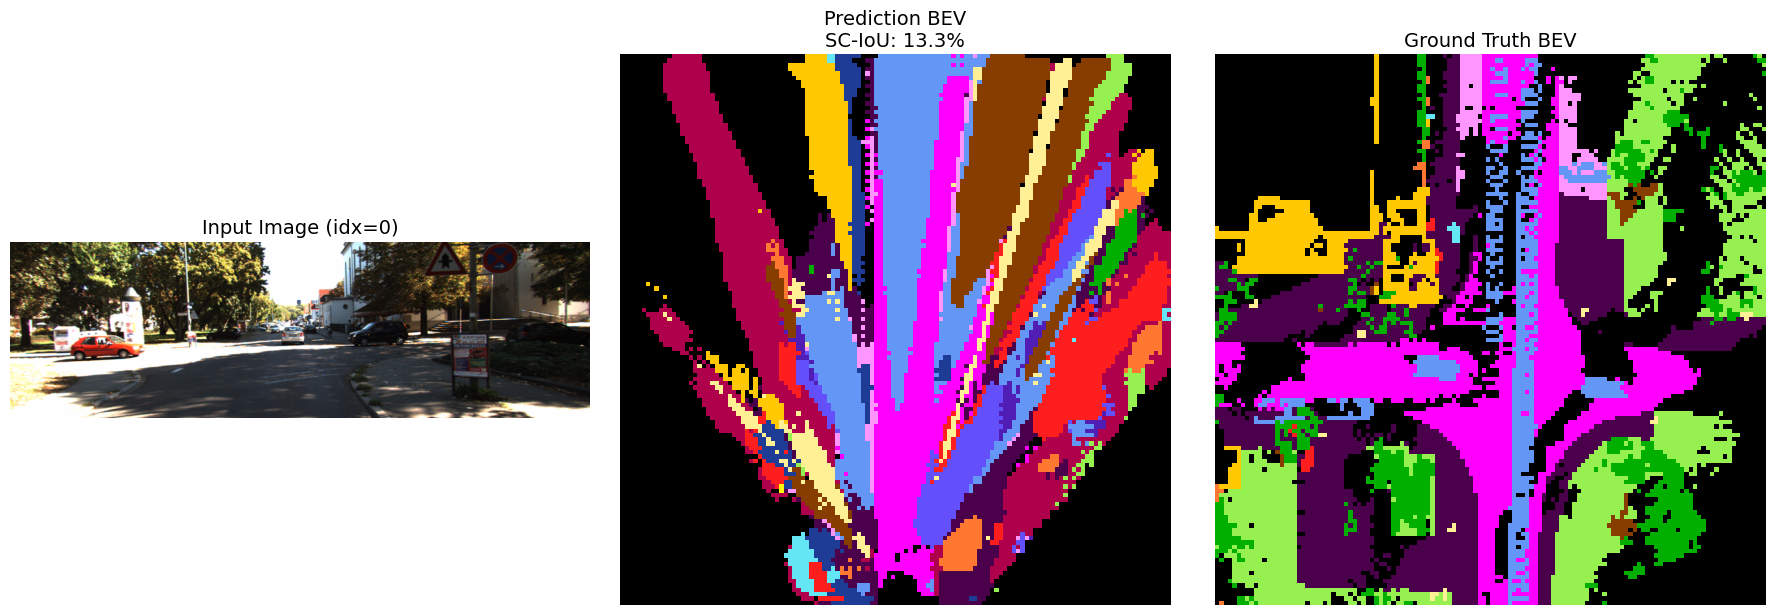

Sample 0: SC-IoU = 13.3%


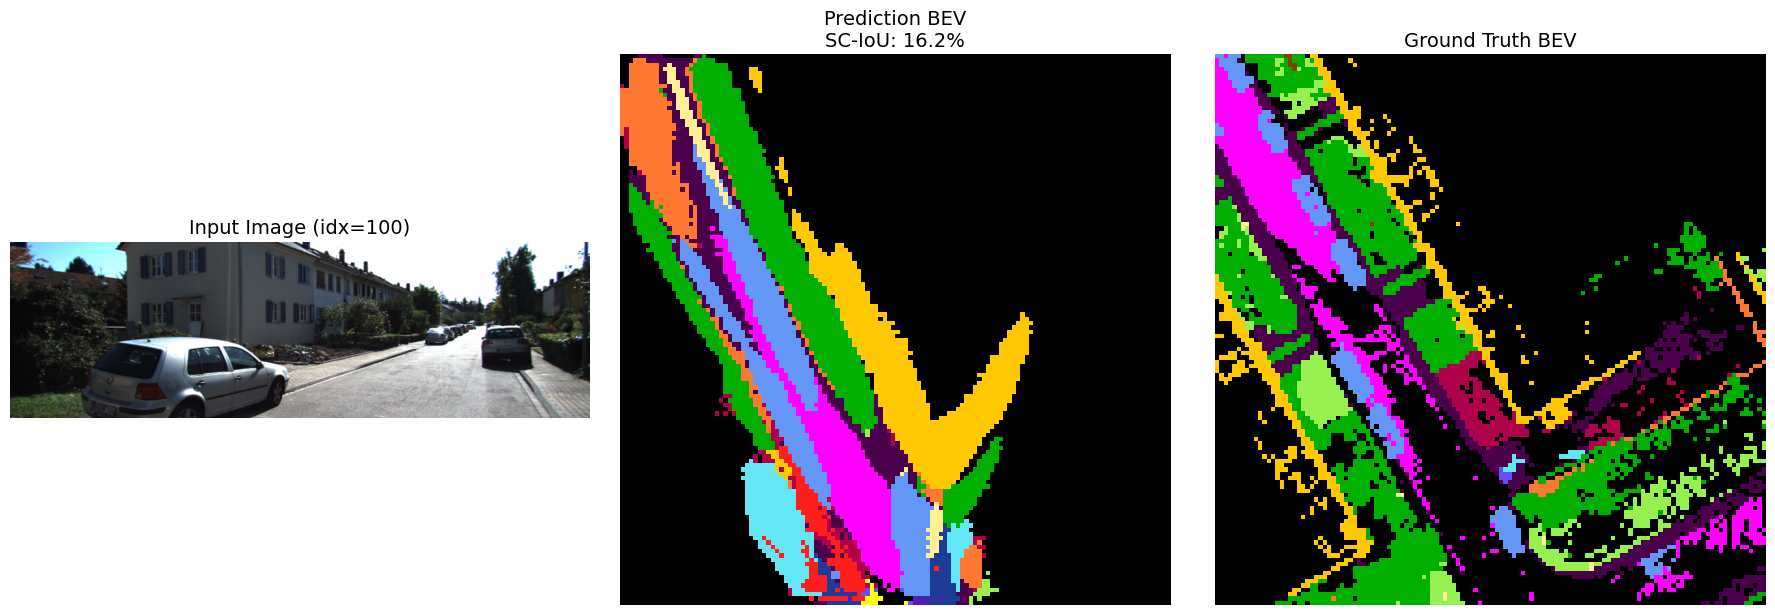

Sample 100: SC-IoU = 16.2%


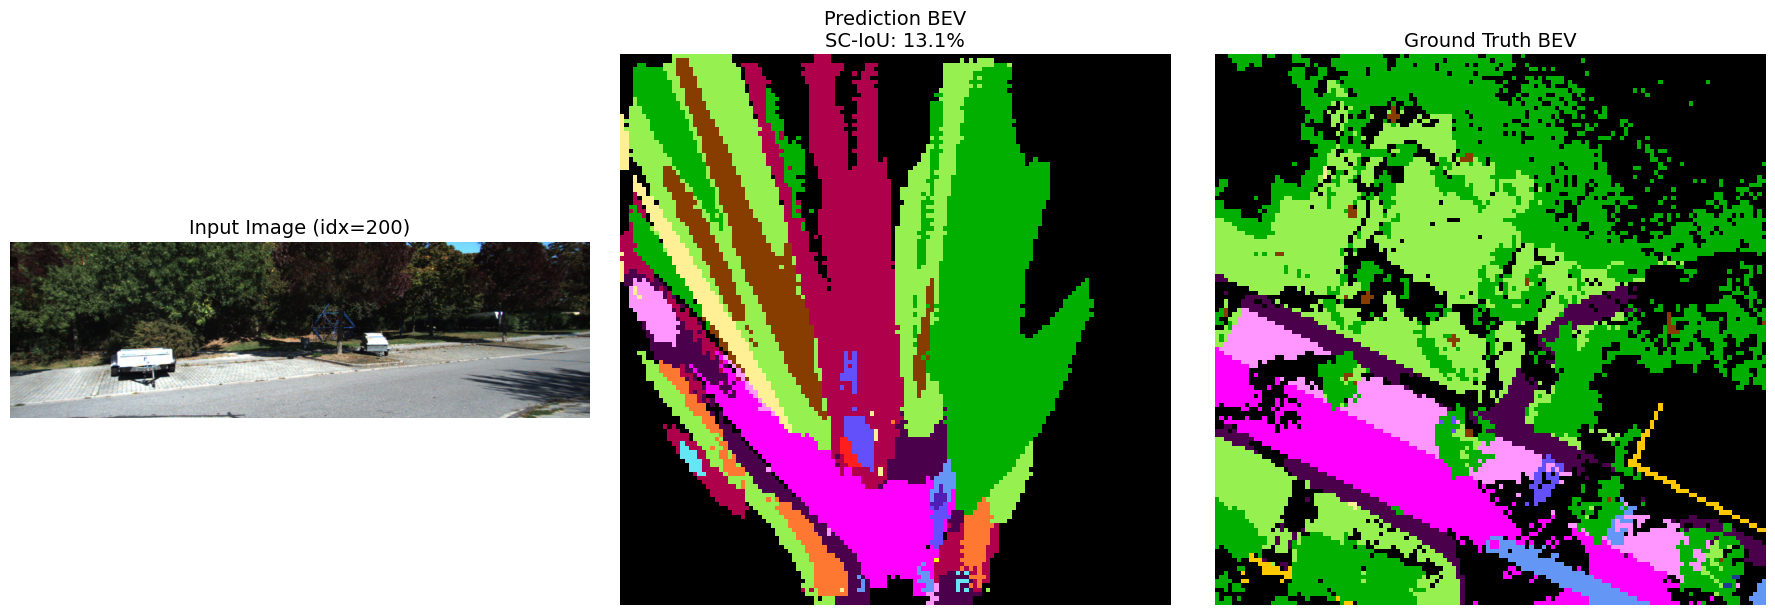

Sample 200: SC-IoU = 13.1%


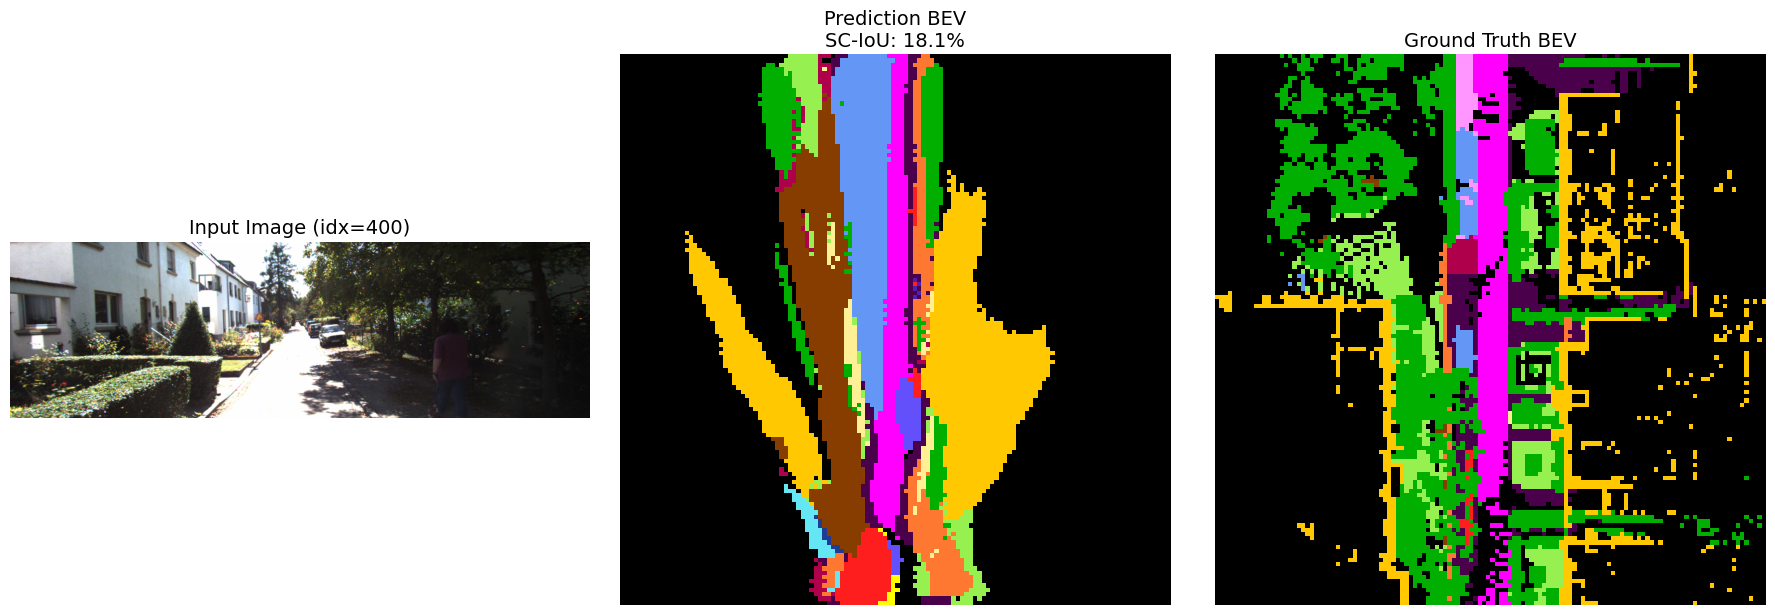

Sample 400: SC-IoU = 18.1%


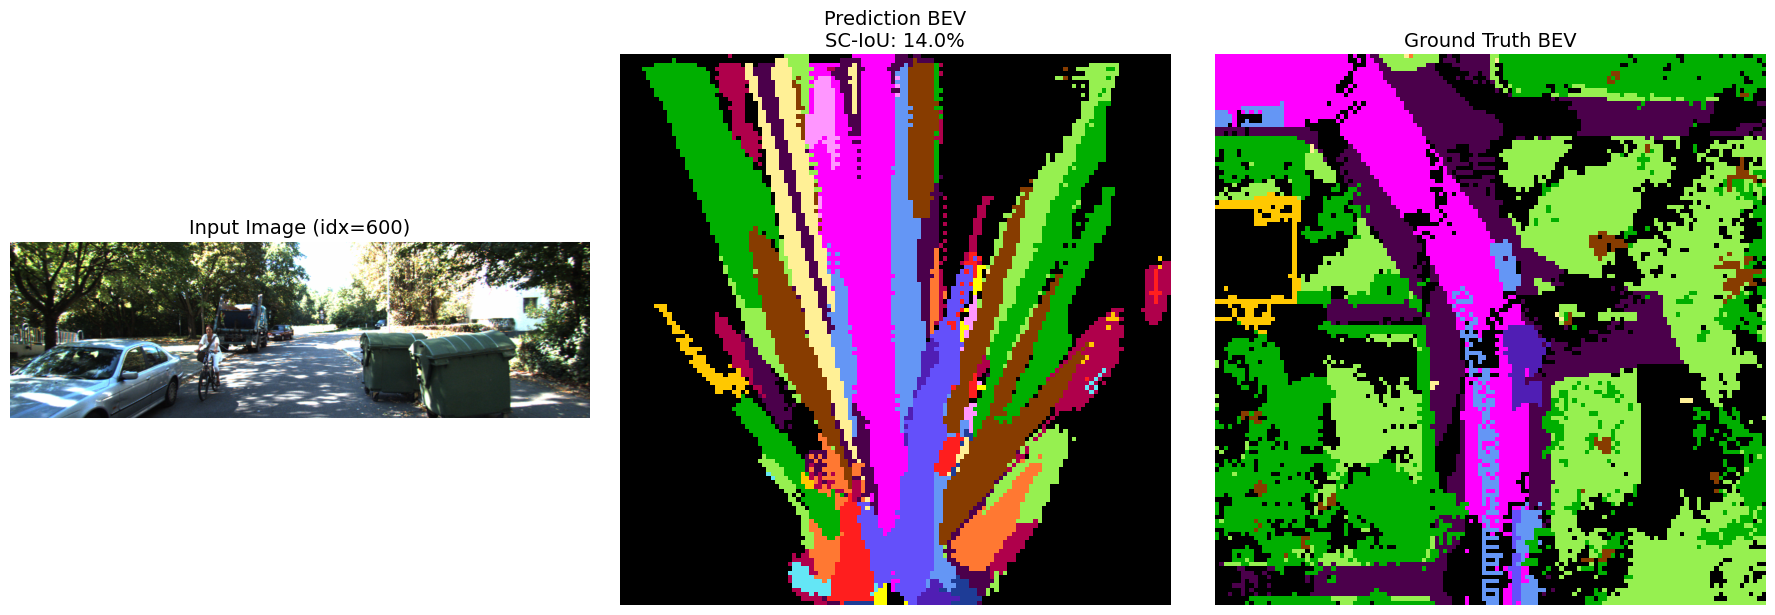

Sample 600: SC-IoU = 14.0%

✅ Done! Saved to /content/drive/MyDrive/Astra/outputs/visualizations


In [37]:

import matplotlib.pyplot as plt
from tqdm import tqdm

# Load checkpoint
print("Loading checkpoint...")
checkpoint_path = os.path.join(DIRS['models_checkpoints'], 'best_v3.pth')
checkpoint = torch.load(checkpoint_path, map_location=device)
print(f"Checkpoint epoch: {checkpoint['epoch']}")
print(f"Checkpoint val_miou: {checkpoint['val_miou']*100:.2f}%")

model = MonoScenePODA(
    num_classes=20,
    voxel_size=(128, 128, 16),
    scene_size=(51.2, 51.2, 6.4),
    voxel_origin=(0.0, -25.6, -2.0),
    device=device
).to(device)

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("✅ Model loaded successfully!")

# Create validation dataset and loader
val_dataset = SemanticKITTIDataset(
    root_path=DIRS['data_semantickitti'],
    split='val',
    img_size=(370, 1220)
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)


print("\n" + "="*60)
print("RUNNING FULL VALIDATION")
print("="*60)

class_intersections = torch.zeros(20, device=device)
class_unions = torch.zeros(20, device=device)
total_sc_iou = 0.0
num_samples = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        K = batch['K'].to(device)
        Tr = batch['Tr_velo_to_cam'].to(device)

        labels_down = labels[:, ::2, ::2, ::2]
        output = model(images, K, Tr, apply_pin=False)
        pred = output.argmax(dim=1)

        valid_mask = labels_down != 255

        # Scene Completion IoU
        pred_occ = (pred > 0) & valid_mask
        target_occ = (labels_down > 0) & valid_mask
        inter = (pred_occ & target_occ).float().sum()
        union = (pred_occ | target_occ).float().sum()
        total_sc_iou += (inter / (union + 1e-6)).item()

        # Per-class IoU
        for c in range(20):
            pred_c = (pred == c) & valid_mask
            target_c = (labels_down == c) & valid_mask
            class_intersections[c] += (pred_c & target_c).float().sum()
            class_unions[c] += (pred_c | target_c).float().sum()

        num_samples += 1

# Compute final metrics
sc_iou = total_sc_iou / num_samples
class_ious = class_intersections / (class_unions + 1e-6)
valid_classes = class_unions > 0
miou = class_ious[valid_classes].mean().item()

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"\nScene Completion IoU: {sc_iou*100:.2f}%")
print(f"Semantic mIoU: {miou*100:.2f}%")
print("\nPer-Class IoU:")
print("-"*40)
for c in range(20):
    if class_unions[c] > 0:
        print(f"  {CLASS_NAMES[c]:15s}: {class_ious[c].item()*100:5.2f}%")
print("="*60)


print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)
DIRS['outputs_visualizations'] = os.path.join(BASE_PATH, 'outputs/visualizations')
os.makedirs(DIRS['outputs_visualizations'], exist_ok=True)

CLASS_COLORS = np.array([
    [0, 0, 0], [100, 150, 245], [100, 230, 245], [30, 60, 150], [80, 30, 180],
    [100, 80, 250], [255, 30, 30], [255, 40, 200], [150, 30, 90], [255, 0, 255],
    [255, 150, 255], [75, 0, 75], [175, 0, 75], [255, 200, 0], [255, 120, 50],
    [255, 255, 0], [0, 175, 0], [135, 60, 0], [150, 240, 80], [255, 240, 150]
]) / 255.0

def get_bev(voxels):
    """Get bird's eye view by taking max class along Z axis"""
    v = voxels.copy()
    v[v == 255] = 0
    bev = np.zeros((v.shape[0], v.shape[1]), dtype=np.int64)
    for z in range(v.shape[2]):
        mask = v[:, :, z] > 0
        bev[mask] = v[:, :, z][mask]
    return bev

for idx in [0, 100, 200, 400, 600]:
    if idx >= len(val_dataset):
        continue

    sample = val_dataset[idx]
    with torch.no_grad():
        images = sample['image'].unsqueeze(0).to(device)
        K = sample['K'].unsqueeze(0).to(device)
        Tr = sample['Tr_velo_to_cam'].unsqueeze(0).to(device)
        output = model(images, K, Tr, apply_pin=False)
        pred = output.argmax(dim=1)[0].cpu().numpy()

    gt = sample['labels'].numpy()[::2, ::2, ::2]

    # Compute sample metrics
    valid = gt != 255
    pred_occ = (pred > 0) & valid
    gt_occ = (gt > 0) & valid
    sample_iou = (pred_occ & gt_occ).sum() / ((pred_occ | gt_occ).sum() + 1e-6)

    # BEV
    pred_bev = get_bev(pred)
    gt_bev = get_bev(gt)

    # Colorize
    pred_rgb = CLASS_COLORS[pred_bev]
    gt_rgb = CLASS_COLORS[gt_bev]

    # Denormalize image for display
    img_np = sample['image'].permute(1, 2, 0).numpy()
    mean = np.array([0.48145466, 0.4578275, 0.40821073])
    std = np.array([0.26862954, 0.26130258, 0.27577711])
    img_np = img_np * std + mean
    img_np = np.clip(img_np, 0, 1)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Input Image (idx={idx})', fontsize=14)
    axes[0].axis('off')

    axes[1].imshow(pred_rgb, origin='lower')
    axes[1].set_title(f'Prediction BEV\nSC-IoU: {sample_iou*100:.1f}%', fontsize=14)
    axes[1].axis('off')

    axes[2].imshow(gt_rgb, origin='lower')
    axes[2].set_title('Ground Truth BEV', fontsize=14)
    axes[2].axis('off')

    plt.tight_layout()
    save_path = os.path.join(DIRS['outputs_visualizations'], f'eval_{idx}.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Sample {idx}: SC-IoU = {sample_iou*100:.1f}%")

print(f"\n✅ Done! Saved to {DIRS['outputs_visualizations']}")

# Mining Styles

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import clip
from tqdm import tqdm
import os
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import json


@dataclass
class StyleMiningConfig:
    """Configuration for style mining."""
    target_prompts: Dict[str, List[str]] = None
    num_optimization_steps: int = 50
    learning_rate: float = 1.0
    momentum: float = 0.9
    batch_size: int = 8
    num_source_images: int = 500
    output_dir: str = "/content/drive/MyDrive/Astra/outputs/mined_styles"

    def __post_init__(self):
        if self.target_prompts is None:
            self.target_prompts = {
                'fog': [
                    "driving in fog",
                    "driving in foggy weather",
                    "driving through thick fog",
                    "navigating roads in misty conditions",
                ],
                'rain': [
                    "driving under rain",
                    "driving in rainy weather",
                    "driving on rain-soaked roads",
                    "navigating through rainfall while driving",
                ],
                'snow': [
                    "driving in snow",
                    "driving on snow-covered roads",
                    "driving in snowy conditions",
                    "navigating a vehicle in snowy terrain",
                ],
            }


class StyleMinerFast:
    """
    Optimized PODA Style Miner with batched processing.
    """

    def __init__(self, clip_model_name: str = 'RN50', device: str = 'cuda'):
        self.device = device

        print(f"Loading CLIP model: {clip_model_name}")
        self.clip_model, self.clip_preprocess = clip.load(clip_model_name, device=device)
        self.clip_model.eval()

        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.visual = self.clip_model.visual
        self.expected_spatial_size = 7

        self.imagenet_templates = [
            'a photo of {}.',
            'a blurry photo of {}.',
            'a photo of the {}.',
            '{}.',
        ]

        print(f"✓ Style Miner initialized on {device}")
        print(f"  GPU: {torch.cuda.get_device_name(device)}")

    def encode_text_prompts(self, prompts: List[str]) -> torch.Tensor:
        """Encode text prompts using CLIP text encoder."""
        all_embeddings = []

        with torch.no_grad():
            for prompt in prompts:
                texts = [template.format(prompt) for template in self.imagenet_templates]
                text_tokens = clip.tokenize(texts).to(self.device)
                text_features = self.clip_model.encode_text(text_tokens)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                all_embeddings.append(text_features.mean(dim=0))

        final_embedding = torch.stack(all_embeddings).mean(dim=0)
        final_embedding = final_embedding / final_embedding.norm()

        return final_embedding

    def get_layer1_features(self, images: torch.Tensor) -> torch.Tensor:
        """Extract Layer1 features from CLIP visual encoder."""
        with torch.no_grad():
            x = images.type(self.visual.conv1.weight.dtype)

            # Stem
            x = self.visual.relu1(self.visual.bn1(self.visual.conv1(x)))
            x = self.visual.relu2(self.visual.bn2(self.visual.conv2(x)))
            x = self.visual.relu3(self.visual.bn3(self.visual.conv3(x)))
            x = self.visual.avgpool(x)

            # Layer1
            x = self.visual.layer1(x)

        return x.float()  # Ensure FP32

    def get_embedding_from_features(self, features: torch.Tensor) -> torch.Tensor:
        """Get CLIP embedding with adaptive pooling for arbitrary spatial sizes."""
        x = features.type(self.visual.layer2[0].conv1.weight.dtype)

        x = self.visual.layer2(x)
        x = self.visual.layer3(x)
        x = self.visual.layer4(x)

        # Adaptive pool to 7x7 before attention pooling
        x = F.adaptive_avg_pool2d(x, (self.expected_spatial_size, self.expected_spatial_size))
        x = self.visual.attnpool(x)

        return x.float()  # Ensure FP32

    def mine_styles_batch(
        self,
        features_batch: torch.Tensor,
        target_embedding: torch.Tensor,
        config: StyleMiningConfig,
    ) -> Tuple[torch.Tensor, torch.Tensor, float]:
        """Mine styles for a batch of features in parallel."""
        B, C, H, W = features_batch.shape

        # Ensure FP32
        features_batch = features_batch.float()
        target_embedding = target_embedding.float()

        # Initialize from source statistics
        mu = features_batch.mean(dim=[2, 3]).clone().requires_grad_(True)  # [B, C]
        sigma = features_batch.std(dim=[2, 3]).clone().requires_grad_(True)  # [B, C]

        optimizer = torch.optim.SGD(
            [mu, sigma],
            lr=config.learning_rate,
            momentum=config.momentum
        )
        target_emb = target_embedding.unsqueeze(0).expand(B, -1)  # [B, embed_dim]

        final_loss = 0.0

        for step in range(config.num_optimization_steps):
            optimizer.zero_grad(set_to_none=True)

            # Batched PIN
            mu_s = features_batch.mean(dim=[2, 3], keepdim=True)
            sigma_s = features_batch.std(dim=[2, 3], keepdim=True) + 1e-6
            f_norm = (features_batch - mu_s) / sigma_s
            f_st = sigma.unsqueeze(-1).unsqueeze(-1) * f_norm + mu.unsqueeze(-1).unsqueeze(-1)

            # Batched embedding
            f_bar_st = self.get_embedding_from_features(f_st)
            f_bar_st = F.normalize(f_bar_st, dim=-1)

            # Batched loss
            cos_sim = (f_bar_st * target_emb).sum(dim=-1)
            loss = (1 - cos_sim).mean()

            loss.backward()
            optimizer.step()

            with torch.no_grad():
                sigma.data.clamp_(min=1e-6)

            final_loss = loss.item()

        return mu.detach(), sigma.detach(), final_loss

    def mine_styles_for_domain(
        self,
        dataloader: torch.utils.data.DataLoader,
        target_prompts: List[str],
        config: StyleMiningConfig,
        domain_name: str,
    ) -> Dict[str, torch.Tensor]:
        """Optimized batched mining for a domain."""
        print(f"\n{'='*60}")
        print(f"Mining styles for domain: {domain_name}")
        print(f"Prompts: {target_prompts}")
        print(f"{'='*60}")

        target_embedding = self.encode_text_prompts(target_prompts)
        print(f"Target embedding shape: {target_embedding.shape}")

        mined_mus = []
        mined_sigmas = []
        all_losses = []
        num_processed = 0

        pbar = tqdm(dataloader, desc=f"Mining {domain_name}")
        for batch in pbar:
            if num_processed >= config.num_source_images:
                break

            images = batch['image'].to(self.device, non_blocking=True)

            with torch.no_grad():
                features = self.get_layer1_features(images)

            # Limit to remaining needed
            remaining = config.num_source_images - num_processed
            if features.shape[0] > remaining:
                features = features[:remaining]

            # Mine entire batch at once
            mu_batch, sigma_batch, loss = self.mine_styles_batch(
                features, target_embedding, config
            )

            mined_mus.append(mu_batch.cpu())
            mined_sigmas.append(sigma_batch.cpu())
            all_losses.append(loss)
            num_processed += features.shape[0]

            pbar.set_postfix({
                'processed': num_processed,
                'loss': f'{loss:.4f}'
            })

        style_bank = {
            'mu': torch.cat(mined_mus, dim=0),
            'sigma': torch.cat(mined_sigmas, dim=0),
        }

        avg_loss = np.mean(all_losses)
        print(f"\n✓ Mined {style_bank['mu'].shape[0]} styles for {domain_name}")
        print(f"  Average final loss: {avg_loss:.4f}")
        print(f"  Style bank shapes: mu={style_bank['mu'].shape}, sigma={style_bank['sigma'].shape}")

        return style_bank


def run_style_mining(
    data_path: str,
    output_dir: str,
    domains: List[str] = None,
    num_source_images: int = 500,
    num_optimization_steps: int = 50,
    batch_size: int = 8,
    device: str = 'cuda',
) -> Dict[str, Dict[str, torch.Tensor]]:
    """Run complete style mining pipeline."""

    print("=" * 60)
    print("PODA STYLE MINING PIPELINE (OPTIMIZED)")
    print("=" * 60)

    # Configuration
    config = StyleMiningConfig(
        num_source_images=num_source_images,
        num_optimization_steps=num_optimization_steps,
        batch_size=batch_size,
        output_dir=output_dir,
    )

    if domains is None:
        domains = list(config.target_prompts.keys())

    os.makedirs(output_dir, exist_ok=True)

    # Load dataset
    print("\n[1/3] Loading source dataset (SemanticKITTI)...")
    source_dataset = SemanticKITTIDataset(
        root_path=data_path,
        split='train',
        img_size=(370, 1220)
    )
    print(f"Loaded {len(source_dataset)} samples")

    source_loader = torch.utils.data.DataLoader(
        source_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # Initialize miner
    print("\n[2/3] Initializing style miner...")
    miner = StyleMinerFast(clip_model_name='RN50', device=device)

    # Mine styles
    print("\n[3/3] Mining styles for target domains...")
    print(f"  - {num_source_images} images per domain")
    print(f"  - {num_optimization_steps} optimization steps")
    print(f"  - Batch size: {batch_size}")

    all_style_banks = {}

    for domain in domains:
        prompts = config.target_prompts[domain]

        style_bank = miner.mine_styles_for_domain(
            dataloader=source_loader,
            target_prompts=prompts,
            config=config,
            domain_name=domain,
        )

        all_style_banks[domain] = style_bank

        # Save individual domain
        save_path = os.path.join(output_dir, f'style_bank_{domain}.pt')
        torch.save(style_bank, save_path)
        print(f"  ✓ Saved to: {save_path}")

    # Save combined
    combined_path = os.path.join(output_dir, 'all_style_banks.pt')
    torch.save(all_style_banks, combined_path)
    print(f"\n✓ All style banks saved to: {combined_path}")

    # Save config
    config_dict = {
        'num_source_images': config.num_source_images,
        'num_optimization_steps': config.num_optimization_steps,
        'learning_rate': config.learning_rate,
        'momentum': config.momentum,
        'batch_size': config.batch_size,
        'target_prompts': config.target_prompts,
        'domains_mined': domains,
    }
    config_path = os.path.join(output_dir, 'mining_config.json')
    with open(config_path, 'w') as f:
        json.dump(config_dict, f, indent=2)
    print(f"✓ Config saved to: {config_path}")

    # Summary
    print("\n" + "=" * 60)
    print("MINING COMPLETE")
    print("=" * 60)
    for domain, bank in all_style_banks.items():
        print(f"  {domain}: {bank['mu'].shape[0]} styles")

    return all_style_banks


DATA_PATH = DIRS['data_semantickitti']
OUTPUT_DIR = os.path.join(DIRS['outputs'], 'mined_styles')

style_banks = run_style_mining(
    data_path=DATA_PATH,
    output_dir=OUTPUT_DIR,
    domains=['fog', 'rain', 'snow'],
    num_source_images=3834,
    num_optimization_steps=100,
    batch_size=8,
    device='cuda',
)

# Verify results
print("\n" + "=" * 60)
print("VERIFICATION")
print("=" * 60)
for domain, bank in style_banks.items():
    mu_mean = bank['mu'].mean().item()
    sigma_mean = bank['sigma'].mean().item()
    print(f"{domain}:")
    print(f"  mu    - shape: {bank['mu'].shape}, mean: {mu_mean:.4f}, std: {bank['mu'].std().item():.4f}")
    print(f"  sigma - shape: {bank['sigma'].shape}, mean: {sigma_mean:.4f}, std: {bank['sigma'].std().item():.4f}")

# Adaptation

In [ ]:

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from typing import Dict, Optional
import gc

# Clear GPU memory before starting
torch.cuda.empty_cache()
gc.collect()

print("=" * 60)
print("PHASE 3: ZERO-SHOT DOMAIN ADAPTATION")
print("=" * 60)


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {DEVICE}")

# Paths
BASE_PATH = "/content/drive/MyDrive/Astra/"
CHECKPOINT_PATH = os.path.join(BASE_PATH, "models/checkpoints/best_v3.pth")
STYLES_DIR = os.path.join(BASE_PATH, "outputs/mined_styles")
DATA_PATH = os.path.join(BASE_PATH, "data/SemanticKITTI")
ADAPTED_CHECKPOINTS_DIR = os.path.join(BASE_PATH, "models/checkpoints/adapted")

os.makedirs(ADAPTED_CHECKPOINTS_DIR, exist_ok=True)

# Target domains
TARGET_DOMAINS = ['fog', 'rain', 'snow']

# Adaptation hyperparameters (per PØDA paper)
ADAPTATION_CONFIG = {
    'num_iterations': 2000,      # Fine-tuning iterations
    'batch_size': 4,
    'lr': 1e-4,                  # Learning rate for CompletionHead
    'weight_decay': 1e-4,
    'log_every': 100,
    'val_every': 500,
}

print(f"\nConfiguration:")
print(f"  Checkpoint: {CHECKPOINT_PATH}")
print(f"  Styles dir: {STYLES_DIR}")
print(f"  Target domains: {TARGET_DOMAINS}")
print(f"  Iterations per domain: {ADAPTATION_CONFIG['num_iterations']}")



print("\n" + "=" * 60)
print("Loading Mined Style Banks")
print("=" * 60)

style_banks = {}
for domain in TARGET_DOMAINS:
    style_path = os.path.join(STYLES_DIR, f"style_bank_{domain}.pt")
    if os.path.exists(style_path):
        style_banks[domain] = torch.load(style_path, map_location='cpu')
        print(f"  ✓ {domain}: mu={style_banks[domain]['mu'].shape}, sigma={style_banks[domain]['sigma'].shape}")
    else:
        print(f"  ✗ {domain}: NOT FOUND at {style_path}")

assert len(style_banks) == len(TARGET_DOMAINS), "Missing style banks!"
print(f"\n✓ Loaded {len(style_banks)} style banks")


# ==============================================================================
# Adaptation Loss (same as training but can optionally drop L_rel)
# ==============================================================================
class AdaptationLoss(nn.Module):
    """
    Simplified loss for adaptation phase.
    Per PØDA paper: L_total = L_ce + L_scal^sem + L_scal^geo + L_fp
    (L_rel is dropped during adaptation)
    """
    def __init__(self, num_classes=20, ignore_index=255):
        super().__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index

        # Class weights (same as training)
        freqs = torch.tensor([
            0.446, 0.039, 0.0002, 0.0002, 0.003, 0.002, 0.0007, 0.0002, 0.0001, 0.153,
            0.011, 0.111, 0.006, 0.141, 0.039, 0.001, 0.393, 0.005, 0.092, 0.003,
        ])
        weights = 1.0 / (freqs + 1e-6)
        weights = weights / weights.sum() * num_classes
        weights[0] = 0.02  # Lower weight for empty class
        self.register_buffer('class_weights', weights)

    def forward(self, pred, target):
        """
        Args:
            pred: [B, C, X, Y, Z] logits
            target: [B, X, Y, Z] class labels
        """
        B, C, X, Y, Z = pred.shape
        device = pred.device

        # Flatten for loss computation
        pred_flat = pred.permute(0, 2, 3, 4, 1).reshape(-1, C)
        target_flat = target.reshape(-1)

        # Valid mask (exclude ignore_index)
        valid_mask = target_flat != self.ignore_index
        if valid_mask.sum() == 0:
            return torch.tensor(0.0, device=device, requires_grad=True)

        pred_valid = pred_flat[valid_mask]
        target_valid = target_flat[valid_mask]

        # Cross-entropy loss
        weights = self.class_weights.to(device)
        ce_loss = F.cross_entropy(pred_valid, target_valid, weight=weights)

        # SCAL loss (simplified - recall term only)
        probs = F.softmax(pred_valid, dim=1)
        scal_loss = 0.0
        num_classes_present = 0

        for c in range(self.num_classes):
            mask_c = (target_valid == c)
            if mask_c.sum() > 0:
                recall = probs[mask_c, c].mean()
                scal_loss -= torch.log(recall + 1e-6)
                num_classes_present += 1

        if num_classes_present > 0:
            scal_loss = scal_loss / num_classes_present

        # Combined loss (with reduced SCAL weight per PØDA)
        total_loss = ce_loss + 0.1 * scal_loss

        return total_loss


# ==============================================================================
# Adaptation Function
# ==============================================================================
def adapt_to_domain(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    style_bank: Dict[str, torch.Tensor],
    domain_name: str,
    config: dict,
    device: torch.device,
) -> nn.Module:
    """
    Adapt model to a target domain using PØDA.

    Protocol:
    1. Freeze everything except CompletionHead
    2. Apply PIN with randomly sampled styles during forward pass
    3. Fine-tune for num_iterations
    """
    print(f"\n{'='*60}")
    print(f"Adapting to domain: {domain_name.upper()}")
    print(f"{'='*60}")

    # Move style bank to device
    mu_bank = style_bank['mu'].to(device)
    sigma_bank = style_bank['sigma'].to(device)
    num_styles = mu_bank.shape[0]
    print(f"Style bank: {num_styles} styles")

    # Freeze everything except completion_head
    for name, param in model.named_parameters():
        if 'completion_head' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # Count trainable params
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")

    # Set model modes
    model.train()
    model.backbone.eval()  # Keep backbone in eval mode (BatchNorm, Dropout)

    # Optimizer (only for completion_head)
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['num_iterations'],
        eta_min=1e-6
    )

    # Loss
    criterion = AdaptationLoss(num_classes=20, ignore_index=255).to(device)

    # Training loop
    train_iter = iter(train_loader)
    best_miou = 0.0
    losses = []

    pbar = tqdm(range(config['num_iterations']), desc=f"Adapting to {domain_name}")

    for iteration in pbar:
        # Get batch (cycle through dataloader)
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            batch = next(train_iter)

        # Move to device
        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        K = batch['K'].to(device)
        Tr = batch['Tr_velo_to_cam'].to(device)

        # Downsample labels from 256x256x32 to 128x128x16
        labels_down = labels[:, ::2, ::2, ::2]

        # Sample random styles for this batch
        B = images.shape[0]
        style_indices = torch.randint(0, num_styles, (B,), device=device)
        pin_mu = mu_bank[style_indices]      # [B, 256]
        pin_sigma = sigma_bank[style_indices]  # [B, 256]

        # Forward with PIN augmentation
        optimizer.zero_grad()
        output = model(images, K, Tr, apply_pin=True, pin_mu=pin_mu, pin_sigma=pin_sigma)

        # Compute loss
        loss = criterion(output, labels_down)

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())

        # Update progress bar
        if iteration % 10 == 0:
            avg_loss = np.mean(losses[-100:]) if len(losses) >= 100 else np.mean(losses)
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg': f'{avg_loss:.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        # Validation
        if (iteration + 1) % config['val_every'] == 0:
            val_metrics = validate_adapted(model, val_loader, device, domain_name, mu_bank, sigma_bank)
            print(f"\n  [Iter {iteration+1}] Val IoU: {val_metrics['iou']:.2f}%, mIoU: {val_metrics['miou']:.2f}%")

            if val_metrics['miou'] > best_miou:
                best_miou = val_metrics['miou']
                # Save best checkpoint
                checkpoint_path = os.path.join(ADAPTED_CHECKPOINTS_DIR, f"adapted_{domain_name}_best.pth")
                torch.save({
                    'iteration': iteration,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'miou': best_miou,
                    'domain': domain_name,
                }, checkpoint_path)
                print(f"  ✓ Saved best checkpoint (mIoU: {best_miou:.2f}%)")

            model.train()
            model.backbone.eval()

    # Final validation
    print(f"\n--- Final Evaluation for {domain_name} ---")
    final_metrics = validate_adapted(model, val_loader, device, domain_name, mu_bank, sigma_bank)
    print(f"Final IoU: {final_metrics['iou']:.2f}%, mIoU: {final_metrics['miou']:.2f}%")

    # Save final checkpoint
    final_path = os.path.join(ADAPTED_CHECKPOINTS_DIR, f"adapted_{domain_name}_final.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'final_miou': final_metrics['miou'],
        'final_iou': final_metrics['iou'],
        'domain': domain_name,
    }, final_path)
    print(f"✓ Saved final checkpoint to {final_path}")

    return model


@torch.no_grad()
def validate_adapted(
    model: nn.Module,
    val_loader: DataLoader,
    device: torch.device,
    domain_name: str,
    mu_bank: torch.Tensor,
    sigma_bank: torch.Tensor,
    max_batches: int = 50,
) -> Dict[str, float]:
    """Validate adapted model with PIN augmentation."""
    model.eval()

    total_iou = 0.0
    class_intersections = torch.zeros(20, device=device)
    class_unions = torch.zeros(20, device=device)
    num_batches = 0
    num_styles = mu_bank.shape[0]

    for batch in val_loader:
        if num_batches >= max_batches:
            break

        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        K = batch['K'].to(device)
        Tr = batch['Tr_velo_to_cam'].to(device)

        labels_down = labels[:, ::2, ::2, ::2]

        # Apply random styles during validation too
        B = images.shape[0]
        style_indices = torch.randint(0, num_styles, (B,), device=device)
        pin_mu = mu_bank[style_indices]
        pin_sigma = sigma_bank[style_indices]

        output = model(images, K, Tr, apply_pin=True, pin_mu=pin_mu, pin_sigma=pin_sigma)
        pred = output.argmax(dim=1)

        # Compute metrics
        valid_mask = labels_down != 255
        pred_occ = (pred > 0) & valid_mask
        target_occ = (labels_down > 0) & valid_mask
        intersection = (pred_occ & target_occ).float().sum()
        union = (pred_occ | target_occ).float().sum()
        total_iou += (intersection / (union + 1e-6)).item()

        for c in range(20):
            pred_c = (pred == c) & valid_mask
            target_c = (labels_down == c) & valid_mask
            class_intersections[c] += (pred_c & target_c).float().sum()
            class_unions[c] += (pred_c | target_c).float().sum()

        num_batches += 1

    # Compute mIoU
    class_ious = class_intersections / (class_unions + 1e-6)
    valid_classes = class_unions > 0
    miou = class_ious[valid_classes].mean().item() * 100 if valid_classes.sum() > 0 else 0.0
    iou = (total_iou / num_batches) * 100 if num_batches > 0 else 0.0

    return {'iou': iou, 'miou': miou}


# ==============================================================================
# Source-Only Baseline Evaluation
# ==============================================================================
@torch.no_grad()
def evaluate_source_only(model, val_loader, device, max_batches=100):
    """Evaluate source-only model (no PIN)."""
    model.eval()

    total_iou = 0.0
    class_intersections = torch.zeros(20, device=device)
    class_unions = torch.zeros(20, device=device)
    num_batches = 0

    print("\nEvaluating source-only baseline...")
    for batch in tqdm(val_loader, desc="Source-only eval"):
        if num_batches >= max_batches:
            break

        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        K = batch['K'].to(device)
        Tr = batch['Tr_velo_to_cam'].to(device)

        labels_down = labels[:, ::2, ::2, ::2]

        # Forward WITHOUT PIN
        output = model(images, K, Tr, apply_pin=False)
        pred = output.argmax(dim=1)

        valid_mask = labels_down != 255
        pred_occ = (pred > 0) & valid_mask
        target_occ = (labels_down > 0) & valid_mask
        intersection = (pred_occ & target_occ).float().sum()
        union = (pred_occ | target_occ).float().sum()
        total_iou += (intersection / (union + 1e-6)).item()

        for c in range(20):
            pred_c = (pred == c) & valid_mask
            target_c = (labels_down == c) & valid_mask
            class_intersections[c] += (pred_c & target_c).float().sum()
            class_unions[c] += (pred_c | target_c).float().sum()

        num_batches += 1

    class_ious = class_intersections / (class_unions + 1e-6)
    valid_classes = class_unions > 0
    miou = class_ious[valid_classes].mean().item() * 100
    iou = (total_iou / num_batches) * 100

    return {'iou': iou, 'miou': miou}


# ==============================================================================
# Main Adaptation Pipeline
# ==============================================================================
def run_adaptation():
    """Run the full adaptation pipeline for all domains."""

    # 1. Load datasets
    print("\n" + "=" * 60)
    print("Loading Datasets")
    print("=" * 60)

    train_dataset = SemanticKITTIDataset(
        root_path=DATA_PATH,
        split='train',
        img_size=(370, 1220)
    )
    val_dataset = SemanticKITTIDataset(
        root_path=DATA_PATH,
        split='val',
        img_size=(370, 1220)
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=ADAPTATION_CONFIG['batch_size'],
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=ADAPTATION_CONFIG['batch_size'],
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")

    # 2. Load source-trained model
    print("\n" + "=" * 60)
    print("Loading Source-Trained Model")
    print("=" * 60)

    model = MonoScenePODA(
        num_classes=20,
        voxel_size=(128, 128, 16),
        scene_size=(51.2, 51.2, 6.4),
        voxel_origin=(0.0, -25.6, -2.0),
        flosp_channels=64,
        unet_base_channels=32,
        device=DEVICE
    ).to(DEVICE)

    # Load checkpoint
    if os.path.exists(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded checkpoint from {CHECKPOINT_PATH}")
        if 'epoch' in checkpoint:
            print(f"  Epoch: {checkpoint['epoch']}")
        if 'val_miou' in checkpoint:
            print(f"  Val mIoU: {checkpoint['val_miou']:.2f}")
    else:
        print(f"✗ Checkpoint not found at {CHECKPOINT_PATH}")
        print("  Using random initialization (NOT RECOMMENDED)")

    # 3. Evaluate source-only baseline
    source_metrics = evaluate_source_only(model, val_loader, DEVICE)
    print(f"\nSource-only baseline:")
    print(f"  IoU: {source_metrics['iou']:.2f}%")
    print(f"  mIoU: {source_metrics['miou']:.2f}%")

    # 4. Adapt to each domain
    results = {'source_only': source_metrics}

    for domain in TARGET_DOMAINS:
        print(f"\n{'#'*60}")
        print(f"# DOMAIN: {domain.upper()}")
        print(f"{'#'*60}")

        # Reload source model for each domain (fresh start)
        model = MonoScenePODA(
            num_classes=20,
            voxel_size=(128, 128, 16),
            scene_size=(51.2, 51.2, 6.4),
            voxel_origin=(0.0, -25.6, -2.0),
            flosp_channels=64,
            unet_base_channels=32,
            device=DEVICE
        ).to(DEVICE)

        if os.path.exists(CHECKPOINT_PATH):
            checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
            model.load_state_dict(checkpoint['model_state_dict'])

        # Adapt
        model = adapt_to_domain(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            style_bank=style_banks[domain],
            domain_name=domain,
            config=ADAPTATION_CONFIG,
            device=DEVICE
        )

        # Final evaluation
        adapted_metrics = validate_adapted(
            model, val_loader, DEVICE, domain,
            style_banks[domain]['mu'].to(DEVICE),
            style_banks[domain]['sigma'].to(DEVICE),
            max_batches=100
        )
        results[domain] = adapted_metrics

        # Clear GPU memory
        torch.cuda.empty_cache()
        gc.collect()

    # 5. Print summary
    print("\n" + "=" * 60)
    print("ADAPTATION RESULTS SUMMARY")
    print("=" * 60)
    print(f"\n{'Domain':<15} {'IoU':>10} {'mIoU':>10} {'Δ mIoU':>10}")
    print("-" * 50)

    source_miou = results['source_only']['miou']
    print(f"{'source_only':<15} {results['source_only']['iou']:>10.2f} {source_miou:>10.2f} {'-':>10}")

    for domain in TARGET_DOMAINS:
        iou = results[domain]['iou']
        miou = results[domain]['miou']
        delta = miou - source_miou
        sign = '+' if delta > 0 else ''
        print(f"{domain:<15} {iou:>10.2f} {miou:>10.2f} {sign}{delta:>9.2f}")

    print("-" * 50)

    # Average improvement
    avg_delta = np.mean([results[d]['miou'] - source_miou for d in TARGET_DOMAINS])
    print(f"{'Average Δ':<15} {'':>10} {'':>10} {'+' if avg_delta > 0 else ''}{avg_delta:>9.2f}")

    return results


# ==============================================================================
# RUN ADAPTATION
# ==============================================================================
if __name__ == "__main__" or True:
    results = run_adaptation()

    print("\n" + "=" * 60)
    print("✓ PHASE 3 COMPLETE!")
    print("=" * 60)
    print(f"\nAdapted checkpoints saved to: {ADAPTED_CHECKPOINTS_DIR}")
    print("\nNext steps:")
    print("  1. Evaluate adapted models on ACDC images (qualitative)")
    print("  2. Compare predictions: source-only vs adapted")
    print("  3. Fine-tune hyperparameters if needed")

In [ ]:


import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import glob


CONFIG = {
    'checkpoint_path': '/content/drive/MyDrive/Astra/models/checkpoints/best_v3.pth',
    'style_dir': '/content/drive/MyDrive/Astra/outputs/mined_styles/',
    'output_dir': '/content/drive/MyDrive/Astra/outputs/adapted_models/',
    'data_root': '/content/drive/MyDrive/Astra/data/SemanticKITTI/',
    'domains': ['fog', 'rain', 'snow'],

    'num_iterations': 8000,
    'batch_size': 4,
    'lr': 1e-4,
    'weight_decay': 1e-4,
    'val_every': 500,

    'use_style_mixing': True,
    'style_mix_prob': 0.5,

    'num_classes': 20,
    'ignore_index': 255,
}


def load_unified_styles(style_dir, domains, device='cuda'):
    """Load and combine all domain style banks."""
    all_mu, all_sigma = [], []

    print(f"Loading style banks from {style_dir}...")
    for domain in domains:
        style_path = os.path.join(style_dir, f'style_bank_{domain}.pt')
        if os.path.exists(style_path):
            style_bank = torch.load(style_path, map_location=device)
            all_mu.append(style_bank['mu'])
            all_sigma.append(style_bank['sigma'])
            print(f"  ✓ {domain}: {style_bank['mu'].shape[0]} styles")
        else:
            print(f"  ✗ {domain}: not found")

    unified_mu = torch.cat(all_mu, dim=0)
    unified_sigma = torch.cat(all_sigma, dim=0)
    print(f"Unified style bank: {unified_mu.shape[0]} total styles")

    return unified_mu, unified_sigma


def sample_styles_with_mixing(unified_mu, unified_sigma, batch_size,
                               source_mu, source_sigma, mix_prob=0.5):
    """Sample styles with optional mixing (per PØDA paper Eq. 5-6)."""
    indices = torch.randint(0, unified_mu.shape[0], (batch_size,))
    target_mu = unified_mu[indices]
    target_sigma = unified_sigma[indices]

    if mix_prob > 0 and source_mu is not None:
        alpha = torch.rand(batch_size, unified_mu.shape[1], device=unified_mu.device)
        do_mix = torch.rand(batch_size, 1, device=unified_mu.device) < mix_prob

        mixed_mu = alpha * target_mu + (1 - alpha) * source_mu
        mixed_sigma = alpha * target_sigma + (1 - alpha) * source_sigma

        final_mu = torch.where(do_mix, mixed_mu, target_mu)
        final_sigma = torch.where(do_mix, mixed_sigma, target_sigma)

        return final_mu, final_sigma

    return target_mu, target_sigma


# =============================================================================
# VALIDATION - WITHOUT PIN
# =============================================================================
def validate_clean(model, val_loader, device, num_batches=50):
    """Validate WITHOUT PIN to measure source domain retention."""
    model.eval()

    total_inter = torch.zeros(CONFIG['num_classes'], device=device)
    total_union = torch.zeros(CONFIG['num_classes'], device=device)

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= num_batches:
                break

            images = batch['image'].to(device)
            labels = batch['labels'].to(device)[:, ::2, ::2, ::2]
            K = batch['K'].to(device)
            Tr = batch['Tr_velo_to_cam'].to(device)

            # NO PIN - clean forward pass
            output = model(images, K, Tr, apply_pin=False)
            pred = output.argmax(dim=1)

            valid_mask = labels != CONFIG['ignore_index']

            for c in range(CONFIG['num_classes']):
                pred_c = (pred == c) & valid_mask
                target_c = (labels == c) & valid_mask
                total_inter[c] += (pred_c & target_c).sum()
                total_union[c] += (pred_c | target_c).sum()

    iou = total_inter / (total_union + 1e-6)
    valid_classes = total_union > 0
    miou = iou[valid_classes].mean().item()
    sc_iou = (total_inter[1:].sum() / (total_union[1:].sum() + 1e-6)).item()

    return miou, sc_iou, iou


# =============================================================================
# MAIN ADAPTATION
# =============================================================================
def run_unified_adaptation():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    os.makedirs(CONFIG['output_dir'], exist_ok=True)

    # -------------------------------------------------------------------------
    # Load source model
    # -------------------------------------------------------------------------
    print("\nLoading source model...")
    checkpoint = torch.load(CONFIG['checkpoint_path'], map_location=device)

    model = MonoScenePODA(
        num_classes=CONFIG['num_classes'],
        voxel_size=(128, 128, 16),
        scene_size=(51.2, 51.2, 6.4),
        voxel_origin=(0.0, -25.6, -2.0),
        device=device
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    print("✓ Source model loaded")

    # -------------------------------------------------------------------------
    # Freeze everything except completion head
    # -------------------------------------------------------------------------
    for name, param in model.named_parameters():
        param.requires_grad = 'completion_head' in name

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable: {trainable:,} parameters")

    # -------------------------------------------------------------------------
    # Load styles
    # -------------------------------------------------------------------------
    unified_mu, unified_sigma = load_unified_styles(
        CONFIG['style_dir'], CONFIG['domains'], device
    )

    # -------------------------------------------------------------------------
    # Datasets
    # -------------------------------------------------------------------------
    print("\nSetting up datasets...")
    train_dataset = SemanticKITTIDataset(root_path=CONFIG['data_root'], split='train')
    val_dataset = SemanticKITTIDataset(root_path=CONFIG['data_root'], split='val')

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                              shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'],
                            shuffle=False, num_workers=4, pin_memory=True)

    # -------------------------------------------------------------------------
    # Baseline
    # -------------------------------------------------------------------------
    print("\n" + "="*60)
    print("SOURCE-ONLY BASELINE (before adaptation)")
    print("="*60)
    baseline_miou, baseline_iou, _ = validate_clean(model, val_loader, device, num_batches=100)
    print(f"Source mIoU: {baseline_miou*100:.2f}%")
    print(f"Source SC-IoU: {baseline_iou*100:.2f}%")

    # -------------------------------------------------------------------------
    # Training setup
    # -------------------------------------------------------------------------
    criterion = SSCLoss(num_classes=CONFIG['num_classes'], ignore_index=CONFIG['ignore_index']).to(device)

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=CONFIG['num_iterations'], eta_min=1e-6
    )

    # -------------------------------------------------------------------------
    # Training loop
    # -------------------------------------------------------------------------
    print(f"\n{'='*60}")
    print(f"UNIFIED ADAPTATION")
    print(f"Domains: {CONFIG['domains']}")
    print(f"Style mixing: {CONFIG['use_style_mixing']} (prob={CONFIG['style_mix_prob']})")
    print(f"{'='*60}\n")

    model.train()
    model.backbone.eval()

    train_iter = iter(train_loader)
    best_miou = 0.0

    pbar = tqdm(range(CONFIG['num_iterations']), desc="Adaptation")

    for iteration in pbar:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            batch = next(train_iter)

        images = batch['image'].to(device)
        labels = batch['labels'].to(device)
        K = batch['K'].to(device)
        Tr = batch['Tr_velo_to_cam'].to(device)

        labels_down = labels[:, ::2, ::2, ::2]

        # Get source statistics for style mixing
        with torch.no_grad():
            x = images.float()
            x = model.backbone.stem_forward(x)
            x = model.backbone.layer1(x)

            source_mu = x.mean(dim=[2, 3])  # [B, 256]
            source_sigma = x.std(dim=[2, 3]) + 1e-6  # [B, 256]

        # Sample styles (with optional mixing)
        if CONFIG['use_style_mixing']:
            pin_mu, pin_sigma = sample_styles_with_mixing(
                unified_mu, unified_sigma, images.shape[0],
                source_mu, source_sigma, CONFIG['style_mix_prob']
            )
        else:
            indices = torch.randint(0, unified_mu.shape[0], (images.shape[0],))
            pin_mu = unified_mu[indices]
            pin_sigma = unified_sigma[indices]

        # Forward with PIN
        optimizer.zero_grad()
        output = model(images, K, Tr, apply_pin=True, pin_mu=pin_mu, pin_sigma=pin_sigma)

        loss = criterion(output, labels_down)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'lr': f'{scheduler.get_last_lr()[0]:.2e}'})

        # Validation - WITHOUT PIN
        if (iteration + 1) % CONFIG['val_every'] == 0:
            miou, sc_iou, class_ious = validate_clean(model, val_loader, device)

            print(f"\nIter {iteration+1}: mIoU={miou*100:.2f}% (baseline: {baseline_miou*100:.2f}%)")

            if miou > best_miou:
                best_miou = miou
                torch.save({
                    'iteration': iteration,
                    'model_state_dict': model.state_dict(),
                    'best_miou': best_miou,
                    'baseline_miou': baseline_miou,
                    'class_ious': class_ious,
                }, os.path.join(CONFIG['output_dir'], 'adapted_unified_best.pth'))
                print(f"★ New best: {best_miou*100:.2f}%")

            model.train()
            model.backbone.eval()

    # -------------------------------------------------------------------------
    # Final
    # -------------------------------------------------------------------------
    print(f"\n{'='*60}")
    print("FINAL RESULTS")
    print(f"{'='*60}")
    print(f"Baseline (source-only): {baseline_miou*100:.2f}%")
    print(f"After adaptation:       {best_miou*100:.2f}%")
    print(f"Change:                 {(best_miou - baseline_miou)*100:+.2f}%")
    print(f"{'='*60}")

    return model, baseline_miou, best_miou


# =============================================================================
# RUN
# =============================================================================
model, baseline, adapted = run_unified_adaptation()

# Eval adapted model

In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import json
from collections import defaultdict
from tqdm import tqdm
from typing import Dict, List, Tuple, Optional

# Paths
SEMANTICSTF_ROOT = '/content/drive/MyDrive/Astra/data/SemanticSTF'
SOURCE_CHECKPOINT = '/content/drive/MyDrive/Astra/models/checkpoints/best_v3.pth'

VOXEL_SIZE = (128, 128, 16)  # Model output size (1:2 scale)
SCENE_SIZE = (51.2, 51.2, 6.4)
VOXEL_ORIGIN = (0.0, -25.6, -2.0)
TARGET_IMAGE_SIZE = (1220, 370)  # Width, Height

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

def load_stf_calibration(root: str) -> Dict:
    """Load and properly scale SemanticSTF calibration."""
    calib_dir = os.path.join(root, 'calib')
    cam_file = os.path.join(calib_dir, 'calib_cam_stereo_left.json')

    # Default KITTI-like calibration as fallback
    default_calib = {
        'K': np.array([
            [707.0912, 0, 601.8873],
            [0, 707.0912, 183.1104],
            [0, 0, 1]
        ], dtype=np.float32),
        'Tr': np.array([
            [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
            [1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
            [9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
            [0, 0, 0, 1]
        ], dtype=np.float32),
        'orig_size': (1226, 370),
        'target_size': TARGET_IMAGE_SIZE,
    }

    if not os.path.exists(cam_file):
        print("  Using default KITTI calibration")
        return default_calib

    with open(cam_file, 'r') as f:
        cam_data = json.load(f)

    # Original STF intrinsics
    K_orig = np.array(cam_data['K'], dtype=np.float32).reshape(3, 3)
    orig_w, orig_h = cam_data['width'], cam_data['height']

    print(f"  Original STF: {orig_w}x{orig_h}")
    print(f"  Original K:\n{K_orig}")

    # Scale intrinsics to target image size
    target_w, target_h = TARGET_IMAGE_SIZE
    scale_x = target_w / orig_w
    scale_y = target_h / orig_h

    K_scaled = K_orig.copy()
    K_scaled[0, 0] *= scale_x  # fx
    K_scaled[0, 2] *= scale_x  # cx
    K_scaled[1, 1] *= scale_y  # fy
    K_scaled[1, 2] *= scale_y  # cy

    print(f"\n  Scaled to: {target_w}x{target_h}")
    print(f"  Scale factors: x={scale_x:.4f}, y={scale_y:.4f}")
    print(f"  Scaled K:\n{K_scaled}")

    # Use KITTI-style lidar-to-camera transform (STF uses similar convention)
    # This transforms from lidar coords to camera optical frame
    Tr = np.array([
        [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
        [1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
        [9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
        [0, 0, 0, 1]
    ], dtype=np.float32)

    return {
        'K': K_scaled,
        'K_orig': K_orig,
        'Tr': Tr,
        'orig_size': (orig_w, orig_h),
        'target_size': TARGET_IMAGE_SIZE,
    }

# =============================================================================
# WEATHER PARSING
# =============================================================================

def parse_weather_txt(root: str, split: str) -> Dict[str, str]:
    """Parse train.txt/val.txt for weather conditions."""
    txt_path = os.path.join(root, split, f'{split}.txt')
    weather_map = {}

    if not os.path.exists(txt_path):
        return weather_map

    with open(txt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            parts = line.split(',')
            if len(parts) >= 2:
                frame_id = parts[0].strip()
                weather = parts[1].strip().lower()
                weather_map[frame_id] = weather

    return weather_map

# =============================================================================
# VOXELIZATION
# =============================================================================

def voxelize_points(
    points: np.ndarray,
    labels: np.ndarray,
    voxel_size: Tuple[int, int, int] = VOXEL_SIZE,
    scene_size: Tuple[float, float, float] = SCENE_SIZE,
    voxel_origin: Tuple[float, float, float] = VOXEL_ORIGIN,
) -> np.ndarray:
    """Voxelize point cloud with semantic labels."""
    X, Y, Z = voxel_size
    sx, sy, sz = scene_size
    ox, oy, oz = voxel_origin
    res_x, res_y, res_z = sx / X, sy / Y, sz / Z

    # Filter points within bounds
    valid = (
        (points[:, 0] >= ox) & (points[:, 0] < ox + sx) &
        (points[:, 1] >= oy) & (points[:, 1] < oy + sy) &
        (points[:, 2] >= oz) & (points[:, 2] < oz + sz)
    )

    pts, lbls = points[valid], labels[valid]
    if len(pts) == 0:
        return np.full(voxel_size, fill_value=255, dtype=np.uint8)

    # STF labels are 0-19 already, but 0 might be unlabeled
    # Mark invalid labels
    lbls = lbls.copy()
    lbls[lbls >= 20] = 255

    # Compute voxel indices
    vx = np.clip(((pts[:, 0] - ox) / res_x).astype(np.int32), 0, X - 1)
    vy = np.clip(((pts[:, 1] - oy) / res_y).astype(np.int32), 0, Y - 1)
    vz = np.clip(((pts[:, 2] - oz) / res_z).astype(np.int32), 0, Z - 1)

    # Majority voting per voxel
    voxel_counts = np.zeros((*voxel_size, 21), dtype=np.int32)  # 0-19 + invalid
    valid_labels = lbls < 20
    np.add.at(voxel_counts, (vx[valid_labels], vy[valid_labels], vz[valid_labels], lbls[valid_labels].astype(np.int32)), 1)

    # Assign label based on majority (prefer non-empty classes 1-19)
    voxel_labels = np.full(voxel_size, fill_value=255, dtype=np.uint8)

    # Count non-empty points per voxel
    has_semantic = voxel_counts[:, :, :, 1:20].sum(axis=-1) > 0
    majority_class = np.argmax(voxel_counts[:, :, :, 1:20], axis=-1) + 1
    voxel_labels[has_semantic] = majority_class[has_semantic]

    # Voxels with only class 0 (empty/unlabeled)
    only_empty = (~has_semantic) & (voxel_counts[:, :, :, 0] > 0)
    voxel_labels[only_empty] = 0

    return voxel_labels

# =============================================================================
# DATASET
# =============================================================================

class SemanticSTFDataset(Dataset):
    """SemanticSTF Dataset with proper calibration."""

    def __init__(
        self,
        root: str,
        split: str = 'train',
        weather_filter: Optional[str] = None,
    ):
        self.root = root
        self.split = split
        self.weather_filter = weather_filter.lower() if weather_filter else None

        # Load calibration with scaling
        print(f"\nLoading calibration for {split}...")
        self.calib = load_stf_calibration(root)

        # Parse weather conditions
        self.weather_map = parse_weather_txt(root, split)
        print(f"  Weather conditions: {dict(defaultdict(int, [(w, list(self.weather_map.values()).count(w)) for w in set(self.weather_map.values())]))}")

        # Collect samples
        self.samples = []
        self._collect_samples()

    def _collect_samples(self):
        split_dir = os.path.join(self.root, self.split)
        velodyne_dir = os.path.join(split_dir, 'velodyne')
        labels_dir = os.path.join(split_dir, 'labels')
        images_dir = os.path.join(split_dir, 'images')

        if not os.path.exists(velodyne_dir):
            print(f"  ❌ Velodyne dir not found: {velodyne_dir}")
            return

        bin_files = sorted(glob.glob(os.path.join(velodyne_dir, '*.bin')))

        for bin_file in bin_files:
            frame_id = os.path.basename(bin_file).replace('.bin', '')
            weather = self.weather_map.get(frame_id, 'unknown')

            # Apply weather filter
            if self.weather_filter and weather != self.weather_filter:
                continue

            # Find label and image
            label_file = os.path.join(labels_dir, f'{frame_id}.label')
            if not os.path.exists(label_file):
                continue

            image_file = None
            for ext in ['.png', '.jpg', '.jpeg']:
                img_path = os.path.join(images_dir, f'{frame_id}{ext}')
                if os.path.exists(img_path):
                    image_file = img_path
                    break

            self.samples.append({
                'frame_id': frame_id,
                'velodyne': bin_file,
                'label': label_file,
                'image': image_file,
                'weather': weather,
            })

        filter_str = f" [{self.weather_filter}]" if self.weather_filter else ""
        print(f"  Loaded {len(self.samples)} samples{filter_str}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load point cloud
        raw = np.fromfile(sample['velodyne'], dtype=np.float32)
        if raw.size % 5 == 0:
            points = raw.reshape(-1, 5)[:, :3]
        elif raw.size % 4 == 0:
            points = raw.reshape(-1, 4)[:, :3]
        else:
            points = raw.reshape(-1, 3)

        # Load labels
        label_data = np.fromfile(sample['label'], dtype=np.uint32)
        labels = (label_data & 0xFFFF).astype(np.uint8)

        # Match sizes
        min_size = min(len(points), len(labels))
        points, labels = points[:min_size], labels[:min_size]

        # Voxelize
        voxel_gt = voxelize_points(points, labels)

        output = {
            'frame_id': sample['frame_id'],
            'weather': sample['weather'],
            'voxel_label': torch.from_numpy(voxel_gt).long(),
        }

        # Load and preprocess image
        if sample['image'] and os.path.exists(sample['image']):
            image = Image.open(sample['image']).convert('RGB')
            image = image.resize(TARGET_IMAGE_SIZE, Image.BILINEAR)

            # CLIP normalization
            img_np = np.array(image).astype(np.float32) / 255.0
            mean = np.array([0.48145466, 0.4578275, 0.40821073])
            std = np.array([0.26862954, 0.26130258, 0.27577711])
            img_np = (img_np - mean) / std

            output['image'] = torch.from_numpy(img_np).permute(2, 0, 1).float()

            # Use SCALED intrinsics
            K_4x4 = np.eye(4, dtype=np.float32)
            K_4x4[:3, :3] = self.calib['K']
            output['intrinsic'] = torch.from_numpy(K_4x4).float()
            output['Tr_velo_to_cam'] = torch.from_numpy(self.calib['Tr']).float()

        return output

# =============================================================================
# METRICS
# =============================================================================
class SSCMetrics:
    """Compute SSC metrics."""

    def __init__(self, num_classes: int = 20, ignore_index: int = 255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()

    def reset(self):
        self.intersection = torch.zeros(self.num_classes)
        self.union = torch.zeros(self.num_classes)
        self.target_count = torch.zeros(self.num_classes)
        self.geo_intersection = 0
        self.geo_union = 0

    @torch.no_grad()
    def update(self, pred: torch.Tensor, target: torch.Tensor):
        """Update with predictions and targets."""
        pred_labels = pred.argmax(dim=1)
        valid = (target != self.ignore_index)

        pred_labels = pred_labels[valid]
        target_labels = target[valid]

        for c in range(self.num_classes):
            pred_c = (pred_labels == c)
            target_c = (target_labels == c)
            self.intersection[c] += (pred_c & target_c).sum().float().cpu()
            self.union[c] += (pred_c | target_c).sum().float().cpu()
            self.target_count[c] += target_c.sum().float().cpu()

        pred_occ = (pred_labels > 0)
        target_occ = (target_labels > 0)
        self.geo_intersection += (pred_occ & target_occ).sum().float().cpu()
        self.geo_union += (pred_occ | target_occ).sum().float().cpu()

    def compute(self) -> Dict[str, float]:
        iou_per_class = self.intersection / (self.union + 1e-5)
        valid_classes = self.target_count > 0
        miou = iou_per_class[valid_classes].mean().item() if valid_classes.sum() > 0 else 0
        geo_iou = (self.geo_intersection / (self.geo_union + 1e-5)).item()

        return {
            'mIoU': miou * 100,
            'IoU': geo_iou * 100,
            'iou_per_class': {i: iou_per_class[i].item() * 100 for i in range(self.num_classes)},
            'valid_classes': valid_classes.sum().item(),
        }

# =============================================================================
# TEST: Verify dataset works
# =============================================================================

print("\n" + "=" * 70)
print("TESTING DATASET")
print("=" * 70)

dataset = SemanticSTFDataset(
    root=SEMANTICSTF_ROOT,
    split='train',
    weather_filter='snow',  # Test with snow first
)

print(f"\nDataset size: {len(dataset)}")

if len(dataset) > 0:
    sample = dataset[0]
    print(f"\nSample keys: {list(sample.keys())}")
    print(f"  voxel_label shape: {sample['voxel_label'].shape}")
    print(f"  voxel_label unique: {torch.unique(sample['voxel_label']).tolist()[:15]}...")

    if 'image' in sample:
        print(f"  image shape: {sample['image'].shape}")
        print(f"  intrinsic shape: {sample['intrinsic'].shape}")
        print(f"  Tr_velo_to_cam shape: {sample['Tr_velo_to_cam'].shape}")

        # Check intrinsic values
        K = sample['intrinsic'][:3, :3]
        print(f"\n  Scaled intrinsics:")
        print(f"    fx={K[0,0].item():.1f}, fy={K[1,1].item():.1f}")
        print(f"    cx={K[0,2].item():.1f}, cy={K[1,2].item():.1f}")

    # Check valid voxel ratio
    valid_voxels = (sample['voxel_label'] != 255).sum().item()
    total_voxels = sample['voxel_label'].numel()
    print(f"\n  Valid voxels: {valid_voxels:,} / {total_voxels:,} ({valid_voxels/total_voxels*100:.1f}%)")

    # Check class distribution
    labels = sample['voxel_label'][sample['voxel_label'] != 255]
    if len(labels) > 0:
        unique, counts = torch.unique(labels, return_counts=True)
        print(f"\n  Label distribution:")
        for lbl, cnt in sorted(zip(unique.tolist(), counts.tolist()), key=lambda x: -x[1])[:8]:
            print(f"    Class {lbl:2d}: {cnt:6,} ({cnt/len(labels)*100:.1f}%)")

In [42]:

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
SEMANTICSTF_ROOT = '/content/drive/MyDrive/Astra/data/SemanticSTF'
SOURCE_CHECKPOINT = '/content/drive/MyDrive/Astra/models/checkpoints/best_v3.pth'

print("=" * 70)
print("LOADING MODEL")
print("=" * 70)

# Load checkpoint
checkpoint = torch.load(SOURCE_CHECKPOINT, map_location=device)
config = checkpoint['config']

model = MonoScenePODA(
    num_classes=config['num_classes'],
    voxel_size=tuple(config['voxel_size']),
    scene_size=tuple(config['scene_size']),
    voxel_origin=tuple(config['voxel_origin']),
    device=device,
)

# Load weights
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✓ Model loaded from epoch {checkpoint['epoch']}")
print(f"  Val IoU: {checkpoint['val_iou']*100:.2f}%")
print(f"  Val mIoU: {checkpoint['val_miou']*100:.2f}%")

# =============================================================================
# EVALUATE ON SemanticSTF
# =============================================================================

print("\n" + "=" * 70)
print("EVALUATING ON SemanticSTF")
print("=" * 70)

weather_conditions = ['snow', 'rain', 'dense_fog', 'light_fog']
results = {}

for weather in weather_conditions:
    print(f"\n--- Weather: {weather} ---")

    # Create dataset
    dataset = SemanticSTFDataset(
        root=SEMANTICSTF_ROOT,
        split='train',
        weather_filter=weather,
    )

    if len(dataset) == 0:
        print(f"  No samples found")
        continue

    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

    # Reset metrics
    metrics = SSCMetrics(num_classes=20, ignore_index=255)

    # Evaluate (limit for quick test)
    max_samples = 30

    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader, total=min(len(dataset), max_samples), desc=f"Eval {weather}")):
            if i >= max_samples:
                break

            images = batch['image'].to(device)
            labels = batch['voxel_label'].to(device)
            intrinsic = batch['intrinsic'].to(device)
            Tr = batch['Tr_velo_to_cam'].to(device)

            outputs = model(
                images,
                intrinsics=intrinsic,
                Tr_velo_to_cam=Tr,
                apply_pin=False,
            )

            # Get predictions
            if isinstance(outputs, dict):
                pred = outputs.get('ssc_logits', outputs.get('pred', list(outputs.values())[0]))
            else:
                pred = outputs

            # Model output is (128, 128, 16), labels are also (128, 128, 16) from voxelization
            labels_down = labels

            # Check shapes
            if pred.shape[2:] != labels_down.shape[1:]:
                scale_x = labels_down.shape[1] // pred.shape[2]
                scale_y = labels_down.shape[2] // pred.shape[3]
                scale_z = labels_down.shape[3] // pred.shape[4]
                if scale_x > 1 or scale_y > 1 or scale_z > 1:
                    labels_down = labels[:, ::max(1,scale_x), ::max(1,scale_y), ::max(1,scale_z)]

            # Update metrics
            metrics.update(pred, labels_down)

    # Compute results
    results[weather] = metrics.compute()
    print(f"  SC-IoU: {results[weather]['IoU']:.2f}%")
    print(f"  mIoU: {results[weather]['mIoU']:.2f}%")

# =============================================================================
# SUMMARY
# =============================================================================

print("\n" + "=" * 70)
print("SUMMARY: Source Model on SemanticSTF")
print("=" * 70)
print(f"\n{'Weather':<15} {'SC-IoU':<10} {'mIoU':<10}")
print("-" * 35)
for weather, m in results.items():
    print(f"{weather:<15} {m['IoU']:>6.2f}%   {m['mIoU']:>6.2f}%")

print(f"\n{'KITTI (ref)':<15} {checkpoint['val_iou']*100:>6.2f}%   {checkpoint['val_miou']*100:>6.2f}%")

LOADING MODEL
✓ Model loaded from epoch 29
  Val IoU: 16.97%
  Val mIoU: 9.33%

EVALUATING ON SemanticSTF

--- Weather: snow ---

Loading calibration for train...
  Original STF: 1920x1024
  Original K:
[[2.61286e+03 0.00000e+00 9.66525e+02]
 [0.00000e+00 2.61286e+03 5.08297e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

  Scaled to: 1220x370
  Scale factors: x=0.6354, y=0.3613
  Scaled K:
[[1.6602549e+03 0.0000000e+00 6.1414612e+02]
 [0.0000000e+00 9.4409985e+02 1.8366200e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
  Weather conditions: {'rain': 66, 'light_fog': 397, 'snow': 460, 'dense_fog': 403}
  Loaded 460 samples [snow]


Eval snow: 100%|██████████| 30/30 [02:23<00:00,  4.79s/it]


  SC-IoU: 20.95%
  mIoU: 2.49%

--- Weather: rain ---

Loading calibration for train...
  Original STF: 1920x1024
  Original K:
[[2.61286e+03 0.00000e+00 9.66525e+02]
 [0.00000e+00 2.61286e+03 5.08297e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

  Scaled to: 1220x370
  Scale factors: x=0.6354, y=0.3613
  Scaled K:
[[1.6602549e+03 0.0000000e+00 6.1414612e+02]
 [0.0000000e+00 9.4409985e+02 1.8366200e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
  Weather conditions: {'rain': 66, 'light_fog': 397, 'snow': 460, 'dense_fog': 403}
  Loaded 66 samples [rain]


Eval rain: 100%|██████████| 30/30 [02:46<00:00,  5.57s/it]


  SC-IoU: 15.66%
  mIoU: 2.27%

--- Weather: dense_fog ---

Loading calibration for train...
  Original STF: 1920x1024
  Original K:
[[2.61286e+03 0.00000e+00 9.66525e+02]
 [0.00000e+00 2.61286e+03 5.08297e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

  Scaled to: 1220x370
  Scale factors: x=0.6354, y=0.3613
  Scaled K:
[[1.6602549e+03 0.0000000e+00 6.1414612e+02]
 [0.0000000e+00 9.4409985e+02 1.8366200e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
  Weather conditions: {'rain': 66, 'light_fog': 397, 'snow': 460, 'dense_fog': 403}
  Loaded 403 samples [dense_fog]


Eval dense_fog: 100%|██████████| 30/30 [01:37<00:00,  3.26s/it]


  SC-IoU: 16.39%
  mIoU: 2.41%

--- Weather: light_fog ---

Loading calibration for train...
  Original STF: 1920x1024
  Original K:
[[2.61286e+03 0.00000e+00 9.66525e+02]
 [0.00000e+00 2.61286e+03 5.08297e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

  Scaled to: 1220x370
  Scale factors: x=0.6354, y=0.3613
  Scaled K:
[[1.6602549e+03 0.0000000e+00 6.1414612e+02]
 [0.0000000e+00 9.4409985e+02 1.8366200e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
  Weather conditions: {'rain': 66, 'light_fog': 397, 'snow': 460, 'dense_fog': 403}
  Loaded 397 samples [light_fog]


Eval light_fog: 100%|██████████| 30/30 [01:46<00:00,  3.55s/it]

  SC-IoU: 20.04%
  mIoU: 2.67%

SUMMARY: Source Model on SemanticSTF

Weather         SC-IoU     mIoU      
-----------------------------------
snow             20.95%     2.49%
rain             15.66%     2.27%
dense_fog        16.39%     2.41%
light_fog        20.04%     2.67%

KITTI (ref)      16.97%     9.33%


In [44]:
# =============================================================================
# EVALUATE ADAPTED MODEL ON SemanticSTF
# =============================================================================

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
SEMANTICSTF_ROOT = '/content/drive/MyDrive/Astra/data/SemanticSTF'
ADAPTED_CHECKPOINT = '/content/drive/MyDrive/Astra/outputs/adapted_models/adapted_unified_best.pth'

print("=" * 70)
print("LOADING ADAPTED MODEL")
print("=" * 70)

# Load adapted checkpoint
adapted_ckpt = torch.load(ADAPTED_CHECKPOINT, map_location=device)

print(f"Adapted checkpoint keys: {list(adapted_ckpt.keys())}")

# Use config from source model (same architecture)
config = {
    'num_classes': 20,
    'voxel_size': (128, 128, 16),
    'scene_size': (51.2, 51.2, 6.4),
    'voxel_origin': (0.0, -25.6, -2.0),
}

# Create model
model = MonoScenePODA(
    num_classes=config['num_classes'],
    voxel_size=config['voxel_size'],
    scene_size=config['scene_size'],
    voxel_origin=config['voxel_origin'],
    device=device,
)

# Load weights - handle different checkpoint formats
if 'model_state_dict' in adapted_ckpt:
    state_dict = adapted_ckpt['model_state_dict']
elif 'state_dict' in adapted_ckpt:
    state_dict = adapted_ckpt['state_dict']
else:
    state_dict = adapted_ckpt

model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print(f"✓ Adapted model loaded")
if 'epoch' in adapted_ckpt:
    print(f"  Epoch: {adapted_ckpt['epoch']}")
if 'val_miou' in adapted_ckpt:
    print(f"  Val mIoU: {adapted_ckpt['val_miou']*100:.2f}%")

# =============================================================================
# EVALUATE
# =============================================================================

print("\n" + "=" * 70)
print("EVALUATING ADAPTED MODEL ON SemanticSTF")
print("=" * 70)

weather_conditions = ['snow', 'rain', 'dense_fog', 'light_fog']
adapted_results = {}

for weather in weather_conditions:
    print(f"\n--- Weather: {weather} ---")

    dataset = SemanticSTFDataset(
        root=SEMANTICSTF_ROOT,
        split='train',
        weather_filter=weather,
    )

    if len(dataset) == 0:
        print(f"  No samples found")
        continue

    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)
    metrics = SSCMetrics(num_classes=20, ignore_index=255)

    max_samples = 30

    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader, total=min(len(dataset), max_samples), desc=f"Eval {weather}")):
            if i >= max_samples:
                break

            images = batch['image'].to(device)
            labels = batch['voxel_label'].to(device)
            intrinsic = batch['intrinsic'].to(device)
            Tr = batch['Tr_velo_to_cam'].to(device)

            outputs = model(images, intrinsics=intrinsic, Tr_velo_to_cam=Tr, apply_pin=False)

            if isinstance(outputs, dict):
                pred = outputs.get('ssc_logits', outputs.get('pred', list(outputs.values())[0]))
            else:
                pred = outputs

            labels_down = labels
            if pred.shape[2:] != labels_down.shape[1:]:
                scale_x = labels_down.shape[1] // pred.shape[2]
                scale_y = labels_down.shape[2] // pred.shape[3]
                scale_z = labels_down.shape[3] // pred.shape[4]
                if scale_x > 1 or scale_y > 1 or scale_z > 1:
                    labels_down = labels[:, ::max(1,scale_x), ::max(1,scale_y), ::max(1,scale_z)]

            metrics.update(pred, labels_down)

    adapted_results[weather] = metrics.compute()
    print(f"  SC-IoU: {adapted_results[weather]['IoU']:.2f}%")
    print(f"  mIoU: {adapted_results[weather]['mIoU']:.2f}%")

# =============================================================================
# COMPARISON SUMMARY
# =============================================================================

print("\n" + "=" * 70)
print("COMPARISON: Source vs Adapted Model on SemanticSTF")
print("=" * 70)

# Source results from previous run
source_results = {
    'snow': {'IoU': 20.95, 'mIoU': 2.49},
    'rain': {'IoU': 15.66, 'mIoU': 2.27},
    'dense_fog': {'IoU': 16.39, 'mIoU': 2.41},
    'light_fog': {'IoU': 20.04, 'mIoU': 2.67},
}

print(f"\n{'Weather':<12} {'Source IoU':<12} {'Adapted IoU':<12} {'Δ IoU':<10} {'Source mIoU':<12} {'Adapted mIoU':<12} {'Δ mIoU':<10}")
print("-" * 90)

for weather in weather_conditions:
    if weather in adapted_results and weather in source_results:
        src = source_results[weather]
        adp = adapted_results[weather]
        delta_iou = adp['IoU'] - src['IoU']
        delta_miou = adp['mIoU'] - src['mIoU']

        print(f"{weather:<12} {src['IoU']:>8.2f}%   {adp['IoU']:>8.2f}%   {delta_iou:>+7.2f}%  {src['mIoU']:>8.2f}%   {adp['mIoU']:>8.2f}%   {delta_miou:>+7.2f}%")

print(f"\n{'KITTI ref':<12} {'16.97%':>11}   {'-':>11}   {'-':>9}  {'9.33%':>11}   {'-':>11}   {'-':>9}")

LOADING ADAPTED MODEL
Adapted checkpoint keys: ['iteration', 'model_state_dict', 'best_miou', 'baseline_miou', 'class_ious']
✓ Adapted model loaded

EVALUATING ADAPTED MODEL ON SemanticSTF

--- Weather: snow ---

Loading calibration for train...
  Original STF: 1920x1024
  Original K:
[[2.61286e+03 0.00000e+00 9.66525e+02]
 [0.00000e+00 2.61286e+03 5.08297e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

  Scaled to: 1220x370
  Scale factors: x=0.6354, y=0.3613
  Scaled K:
[[1.6602549e+03 0.0000000e+00 6.1414612e+02]
 [0.0000000e+00 9.4409985e+02 1.8366200e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
  Weather conditions: {'rain': 66, 'light_fog': 397, 'snow': 460, 'dense_fog': 403}
  Loaded 460 samples [snow]


Eval snow: 100%|██████████| 30/30 [00:09<00:00,  3.04it/s]


  SC-IoU: 41.84%
  mIoU: 4.44%

--- Weather: rain ---

Loading calibration for train...
  Original STF: 1920x1024
  Original K:
[[2.61286e+03 0.00000e+00 9.66525e+02]
 [0.00000e+00 2.61286e+03 5.08297e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

  Scaled to: 1220x370
  Scale factors: x=0.6354, y=0.3613
  Scaled K:
[[1.6602549e+03 0.0000000e+00 6.1414612e+02]
 [0.0000000e+00 9.4409985e+02 1.8366200e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
  Weather conditions: {'rain': 66, 'light_fog': 397, 'snow': 460, 'dense_fog': 403}
  Loaded 66 samples [rain]


Eval rain: 100%|██████████| 30/30 [00:04<00:00,  6.11it/s]


  SC-IoU: 39.87%
  mIoU: 4.60%

--- Weather: dense_fog ---

Loading calibration for train...
  Original STF: 1920x1024
  Original K:
[[2.61286e+03 0.00000e+00 9.66525e+02]
 [0.00000e+00 2.61286e+03 5.08297e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

  Scaled to: 1220x370
  Scale factors: x=0.6354, y=0.3613
  Scaled K:
[[1.6602549e+03 0.0000000e+00 6.1414612e+02]
 [0.0000000e+00 9.4409985e+02 1.8366200e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
  Weather conditions: {'rain': 66, 'light_fog': 397, 'snow': 460, 'dense_fog': 403}
  Loaded 403 samples [dense_fog]


Eval dense_fog: 100%|██████████| 30/30 [00:04<00:00,  6.21it/s]


  SC-IoU: 47.50%
  mIoU: 6.07%

--- Weather: light_fog ---

Loading calibration for train...
  Original STF: 1920x1024
  Original K:
[[2.61286e+03 0.00000e+00 9.66525e+02]
 [0.00000e+00 2.61286e+03 5.08297e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]

  Scaled to: 1220x370
  Scale factors: x=0.6354, y=0.3613
  Scaled K:
[[1.6602549e+03 0.0000000e+00 6.1414612e+02]
 [0.0000000e+00 9.4409985e+02 1.8366200e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
  Weather conditions: {'rain': 66, 'light_fog': 397, 'snow': 460, 'dense_fog': 403}
  Loaded 397 samples [light_fog]


Eval light_fog: 100%|██████████| 30/30 [00:04<00:00,  6.02it/s]

  SC-IoU: 50.76%
  mIoU: 5.03%

COMPARISON: Source vs Adapted Model on SemanticSTF

Weather      Source IoU   Adapted IoU  Δ IoU      Source mIoU  Adapted mIoU Δ mIoU    
------------------------------------------------------------------------------------------
snow            20.95%      41.84%    +20.89%      2.49%       4.44%     +1.95%
rain            15.66%      39.87%    +24.21%      2.27%       4.60%     +2.33%
dense_fog       16.39%      47.50%    +31.11%      2.41%       6.07%     +3.66%
light_fog       20.04%      50.76%    +30.72%      2.67%       5.03%     +2.36%

KITTI ref         16.97%             -           -        9.33%             -           -
